# Analysis of CyloD Runs at Different Timescales

To analyse:

- Total cost
- Change in performance with ensemble size
- How results would change with smaller dynamic range - how big does the free energy difference have to be to discriminate ligands?
    - dG at which we discriminate right 90 % of the time?

In [1]:
import a3fe as a3
from a3fe.read._read_exp_dgs import read_exp_dgs
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from typing import Dict as _Dict
from typing import List as _List
import pickle as pkl
from typing import Tuple as _Tuple

import numpy as _np
import pandas as _pd
from scipy import stats as _stats
from sklearn import metrics as _metrics
from matplotlib import pyplot as plt
from scipy.stats import linregress
from copy import deepcopy

INFO:rdkit:Enabling RDKit 2023.09.5 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


## Extract Data

In [2]:
results_sets = {"0.01 ns": "results_001.pkl",
                "0.1 ns": "results_01.pkl",
                "5 ns": "results_5.pkl" }

In [3]:
# Read in all the data
def read_res(f):
    with open(f, "rb") as f:
        return pkl.load(f)

results_dicts = {name: read_res(file) for name, file in results_sets.items()}

In [4]:
# Change the keys "dg" to "dgs" and "er" to "err"

results = {name :{lig.split("/")[-1]: {k.replace("dg", "dgs").replace("er", "err"): v for k, v in results[lig].items()} for lig in results} for name, results in results_dicts.items()}

In [5]:
results["0.01 ns"]

{'lig_39_cry_pose_5000ps': {'dgs': array([-26.86373321, -37.50440821, -29.62947221, -25.03017121,
         -29.53117921]),
  'err': array([2.9112051 , 3.01894477, 2.79937709, 2.50870583, 2.66389467])},
 'lig_27_5000ps': {'dgs': array([-26.48009063, -30.38866563, -27.11620763, -22.27252063,
         -28.71913563]),
  'err': array([3.06451733, 2.28983992, 2.55767027, 3.08083372, 2.67836578])},
 'lig_2_5000ps': {'dgs': array([-19.57327707, -26.62951107, -24.52173907, -23.56169807,
         -17.71542607]),
  'err': array([2.70383339, 2.42080734, 2.51947306, 2.47795603, 2.57161484])},
 'lig_16_5000ps': {'dgs': array([-30.71940919, -28.52437319, -24.78861419, -27.39232519,
         -21.89465919]),
  'err': array([3.434962  , 2.96506742, 3.49618866, 2.70494363, 2.88911137])},
 'lig_14_5000ps': {'dgs': array([-25.4751082, -33.5588972, -40.2699052, -28.0549092, -35.8182462]),
  'err': array([4.49136041, 2.87984604, 3.39646168, 4.92221176, 3.15528958])},
 'lig_40_5000ps': {'dgs': array([-25.5080

In [6]:
all_results = results

In [7]:
# Read in experimental results
exp_dgs = read_exp_dgs("input/exp_dgs_fixed.csv")

In [8]:
# Add the caculated results to the dataframe

dfs = {}
for name, results_dict in results.items():
    all_dgs = deepcopy(exp_dgs)
    for i in range(1, 6):
        all_dgs[f"calc_dg_{i}"] = np.nan
        all_dgs[f"calc_er_{i}"] = np.nan

    for calc_path in results_dict:
        for i in range(5):
            all_dgs.loc[calc_path, f"calc_dg_{i+1}"] = results_dict[calc_path]["dgs"][i]
            all_dgs.loc[calc_path, f"calc_er_{i+1}"] = results_dict[calc_path]["err"][i]
        dgs = np.array(results_dict[calc_path]["dgs"])
        all_dgs.loc[calc_path, "calc_dg"] = dgs.mean()
        conf_int = (
            _stats.t.interval(
                0.95,
                len(dgs) - 1,
                dgs.mean(),
                scale=_stats.sem(dgs),
            )[1]
            - dgs.mean()
        )  # 95 % C.I.
        all_dgs.loc[calc_path,"calc_er"] = conf_int
    
    dfs[name] = all_dgs


In [9]:
dfs["0.01 ns"]

,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,calc_dg,calc_er
name,,,,,,,,,,,,,,,,
lig_2_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-9.06,0.5,0,-19.573277,2.703833,-26.629511,2.420807,-24.521739,2.519473,-23.561698,2.477956,-17.715426,2.571615,-22.400330,4.548444
lig_3_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.93,0.5,0,-17.219189,1.406255,-14.419319,1.514644,-16.168314,1.470050,-14.775480,1.438497,-9.868251,1.462194,-14.490111,3.496131
lig_8_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-4.04,0.5,0,-17.449927,1.858630,-20.688500,1.855671,-19.366156,1.789039,-15.549094,1.787209,-17.454774,1.848317,-18.101690,2.455977
lig_14_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-11.22,0.5,0,-25.475108,4.491360,-33.558897,2.879846,-40.269905,3.396462,-28.054909,4.922212,-35.818246,3.155290,-32.635413,7.385545
lig_16_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.42,0.5,0,-30.719409,3.434962,-28.524373,2.965067,-24.788614,3.496189,-27.392325,2.704944,-21.894659,2.889111,-26.663876,4.242671
lig_27_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-7.57,0.5,0,-26.480091,3.064517,-30.388666,2.289840,-27.116208,2.557670,-22.272521,3.080834,-28.719136,2.678366,-26.995324,3.780008
lig_39_cry_pose_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.43,0.5,0,-26.863733,2.911205,-37.504408,3.018945,-29.629472,2.799377,-25.030171,2.508706,-29.531179,2.663895,-29.711793,5.915629
lig_40_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.08,0.5,0,-25.508004,2.548230,-25.732089,2.465175,-29.166539,2.478495,-25.957981,2.593975,-24.134780,2.557985,-26.099878,2.303926
lig_4_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.90,0.5,0,-20.107779,1.961153,-11.153166,2.018300,-14.802624,1.936519,-18.963884,2.148775,-14.604069,2.093537,-15.926305,4.498588


In [10]:
dfs["0.1 ns"]

,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,calc_dg,calc_er
name,,,,,,,,,,,,,,,,
lig_2_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-9.06,0.5,0,-12.676660,0.876516,-13.134207,0.905293,-15.293629,0.880107,-14.277321,0.918129,-11.119841,0.859508,-13.300332,1.972922
lig_3_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.93,0.5,0,-5.883319,0.519522,-7.328985,0.527703,-7.046966,0.527501,-7.729038,0.524869,-6.831234,0.526401,-6.963908,0.858204
lig_8_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-4.04,0.5,0,-8.967789,0.633453,-9.480897,0.630158,-8.498554,0.644384,-9.489845,0.633565,-8.444839,0.624960,-8.976385,0.629804
lig_14_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-11.22,0.5,0,-23.224589,1.049110,-20.448463,1.067740,-22.518294,1.050137,-19.183747,1.140323,-19.402604,1.032052,-20.955540,2.272514
lig_16_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.42,0.5,0,-12.994454,1.062156,-14.985166,1.047665,-17.091428,1.045282,-9.721661,1.089655,-15.725500,1.009165,-14.103642,3.553765
lig_27_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-7.57,0.5,0,-14.833395,0.869798,-11.853940,0.837974,-10.826180,0.845081,-14.215652,0.840146,-17.880808,0.855052,-13.921995,3.425846
lig_39_cry_pose_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.43,0.5,0,-19.935935,0.910934,-16.202916,0.937059,-20.653419,0.876178,-20.104514,0.941854,-17.165960,0.929923,-18.812549,2.470990
lig_40_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.08,0.5,0,-16.955944,0.894675,-20.571480,0.873786,-21.546745,0.840888,-14.972574,0.919128,-21.694315,0.898790,-19.148211,3.750940
lig_4_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.90,0.5,0,-9.750347,0.684243,-8.767208,0.688654,-12.377274,0.662533,-7.754762,0.698323,-7.891517,0.691055,-9.308222,2.349957


In [11]:
dfs["5 ns"]

,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,calc_dg,calc_er
name,,,,,,,,,,,,,,,,
lig_2_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-9.06,0.5,0,-11.014637,0.141236,-11.672850,0.144615,-10.194584,0.140045,-10.637021,0.139709,-9.078210,0.142007,-10.519460,1.205769
lig_3_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.93,0.5,0,-5.973352,0.084524,-4.196742,0.085045,-5.143862,0.084844,-3.406779,0.085606,-4.944808,0.085045,-4.733109,1.209998
lig_8_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-4.04,0.5,0,-7.356388,0.101510,-5.917005,0.102190,-8.118225,0.101627,-7.828838,0.101517,-7.496912,0.100498,-7.343473,1.056207
lig_14_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-11.22,0.5,0,-15.153515,0.172338,-14.841690,0.176459,-14.612056,0.174830,-17.406517,0.170593,-15.204817,0.172183,-15.443719,1.394866
lig_16_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.42,0.5,0,-9.498328,0.170664,-9.268065,0.168827,-13.189106,0.167240,-10.934803,0.168371,-9.549646,0.169975,-10.487990,2.044396
lig_27_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-7.57,0.5,0,-11.849641,0.137542,-11.282158,0.136248,-11.439265,0.134782,-10.525741,0.137849,-8.955546,0.138877,-10.810470,1.418375
lig_39_cry_pose_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.43,0.5,0,-14.518784,0.145773,-14.172520,0.147996,-13.669709,0.147258,-13.306164,0.147186,-12.242494,0.149584,-13.581934,1.093851
lig_40_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-8.08,0.5,0,-13.875614,0.142643,-13.939428,0.141967,-15.449710,0.140593,-14.781523,0.143724,-14.506129,0.141617,-14.510481,0.805837
lig_4_5000ps,/home/finlayclark/Documents/research/fast_abfe...,-2.90,0.5,0,-7.098130,0.110220,-5.341186,0.111411,-6.390398,0.110459,-9.239754,0.109124,-6.615518,0.110020,-6.936997,1.786161


## Total Cost

In [24]:
tot_gpu_time = 0
tot_sim_time = 0

for calc_path in calc_set.calc_paths:
    calc = a3.Calculation(base_dir=calc_path)
    tot_gpu_time += calc.tot_gpu_time
    tot_sim_time += calc.tot_simtime
    calc._close_logging_handlers()
    del calc

print(f"Total GPU Time: {tot_gpu_time} GPU Hours")
print(f"Total simulation time: {tot_sim_time} ns")

Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...


/projects/cc/clark_kbtd104/software/miniforge3/envs/maize-contrib-a3fe/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calculation. Any arguments will be overwritten...
Setting up logging...
Loading previous Calc

## Overall Performance

In [12]:

def compute_stats(
    all_results: _pd.DataFrame, n_replicates: int
) -> _Dict[str, _List[float]]:
    """
    Compute statistics for the passed results, generating 95 % C.I.s
    by bootstrapping.

    Parameters
    ----------
    all_results : pd.DataFrame
        The dataframe containing all results.

    n_replicates: int
        If the results contain multiple calc_dg_i columns, this is the number
        of replicates that will be resampled when bootstrapping. E.g. this computes
        the statistics as if we had only run n_replicates calculations, but with
        our calculated data where we may have more than n_replicates calculations.

    Returns
    -------
    Dict[str, List[float]]
        A dictionary of the computed statistics, and their upper and lower
        confidence bounds.
    """

    # This will hold metric: [value, upper_err, lower_er]
    results = {"r": [], "r2": [], "mue": [], "rmse": [], "rho": [], "tau": []}

    # Get the bootstrapped results
    n_bootstrap = 1000
    bootstrapped_exp_dg, bootstrapped_calc_dg = get_bootstrapped_results(
        all_results=all_results, n_bootstrap=n_bootstrap, n_replicates=n_replicates
    )

    # Check if we have a single calc_dg column or multiple calc_dg_i columns
    # If we have multiple, we need to calcuate the mean to get the mean
    #  statistic
    multi_calc_dg = "calc_dg" not in all_results.columns
    if multi_calc_dg:
        calc_dg_series = all_results.filter(like="calc_dg").mean(axis=1)
    else:
        calc_dg_series = all_results["calc_dg"]

    # For each metric, calculate i) over the actual data ii) overall bootstrapped data and extract stats
    for metric in results:
        results[metric].append(
            compute_statistic(all_results["exp_dg"], calc_dg_series, metric)
        )
        bootstrapped_metric = _np.zeros([n_bootstrap])
        for i in range(n_bootstrap):
            bootstrapped_metric[i] = compute_statistic(
                bootstrapped_exp_dg[i], bootstrapped_calc_dg[i], metric
            )
        # Get the median
        # results[metric].append(_np.median(bootstrapped_metric))
        # Get the 95 % C.I.s
        percentiles = _np.percentile(bootstrapped_metric, [5, 95])  # 95 % C.I.s
        results[metric].append(percentiles[0])
        results[metric].append(percentiles[1])

    return results


def get_bootstrapped_results(
    all_results: _pd.DataFrame,
    n_replicates: int,
    n_bootstrap: int = 1000,
) -> _Tuple[_np.ndarray, _np.ndarray]:
    """
    Return n_bootstrap bootstrapped versions of the original experimental
    and calculated free energies.

    Parameters
    ----------
    all_results : pd.DataFrame
        The dataframe containing all results. If there is a single calc_dg
        column and a single calc_er column, the calc_er column will be used
        to create a Gaussian distribution around the calculated dg for bootstrapping
        (assuming this is a 95 % CI). If several calc_dg_1, calc_dg_2, etc. columns
        are present, then the invidual dg results will be bootstrapped.

    n_replicates: int
        If the results contain multiple calc_dg_i columns, this is the number
        of replicates that will be resampled when bootstrapping. E.g. this computes
        the statistics as if we had only run n_replicates calculations, but with
        our calculated data where we may have more than n_replicates calculations.

    n_bootstrap : int, optional, default = 1000
        Number of boostrap iterations to perform

    Returns
    -------
    boostrapped_exp_dg: np.ndarray
        The bootstrapped experimental free energy changes
    bootstrapped_calc_dg: np_ndarray
        The bootstrapped calculated free energy changes
    """
    # Decide whether to sample from Gaussians, if only one calc_dg column
    # is provided, or to sample from the individual columns
    method = "gaussian" if "calc_dg" in all_results.columns else "individual"
    if method == "individual":
        n_repeats_real = len([col for col in all_results.columns if "calc_dg" in col])
        if n_replicates > n_repeats_real:
            raise ValueError(
                f"n_replicates must be less than or equal to the number of calc_dg columns, "
                f"which is {n_repeats_real}, but was {n_replicates}"
            )
    else:
        calc_dg = all_results["calc_dg"]

    exp_dg = all_results["exp_dg"]
    exp_sem = all_results["exp_er"] / 1.96
    if method == "gaussian":
        calc_sem = all_results["calc_er"] / 1.96

    n_samples = len(exp_dg)

    bootstrapped_exp_dg = _np.zeros([n_bootstrap, n_samples])
    bootstrapped_calc_dg = _np.zeros([n_bootstrap, n_samples])
    for i in range(n_bootstrap):
        # Ensure we use same indices for the experimental and calculated results to avoid mixing
        # results
        indices = _np.random.choice(_np.arange(n_samples), size=n_samples, replace=True)
        bootstrapped_exp_dg[i] = _np.array(
            [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
        )
        if method == "gaussian":
            bootstrapped_calc_dg[i] = _np.array(
                [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]
            )
        else:
            # Resample from the indices calculations, and for each calcuation, resample from the n_repeats
            # columns and take the mean
            bootstrapped_calc_dg[i] = _np.array(
                [
                    _np.mean(
                        [
                            all_results[f"calc_dg_{j}"][i]
                            for j in _np.random.choice(
                                _np.arange(start=1, stop=n_repeats_real + 1),
                                size=n_replicates,
                                replace=True,
                            )
                        ]
                    )
                    for i in indices
                ]
            )

    return bootstrapped_exp_dg, bootstrapped_calc_dg


def compute_statistic(exp_dg: _pd.Series, calc_dg: _pd.Series, statistic: str) -> float:
    """
    Compute the desired statistic for one set of experimental and
    calculated values.

    Parameters
    ----------
    exp_dg : pd.Series
        The experimental free energies
    calc_dg : pd.Series
        The calculated free energies
    statistic : str
        The desired statistic to be calculated, from "r", "mue", "rmse"
        "rho", or "tau".

    Returns
    -------
    float
        The desired statistic.
    """
    # Check that requested metric is implemented
    allowed_stats = ["r", "r2", "mue", "rmse", "rho", "tau"]
    if statistic not in allowed_stats:
        raise ValueError(
            f"Statistic must be one of {allowed_stats} but was {statistic}"
        )

    if statistic == "r":
        return _stats.pearsonr(exp_dg, calc_dg)[0]
    if statistic == "r2":
        m, c, r, p, sem = _stats.linregress(exp_dg, calc_dg)
        return r**2
    if statistic == "mue":
        return _metrics.mean_absolute_error(exp_dg, calc_dg)
    if statistic == "rmse":
        return _np.sqrt(_metrics.mean_squared_error(exp_dg, calc_dg))
    if statistic == "rho":
        return _stats.spearmanr(exp_dg, calc_dg)[0]
    if statistic == "tau":
        return _stats.kendalltau(exp_dg, calc_dg)[0]


In [35]:
import matplotlib.pyplot as _plt
from typing import Dict as _Dict, Optional as _Optional

def plot_against_exp(
    all_results: _pd.DataFrame,
    output_dir: str,
    offset: bool = False,
    stats: _Optional[_Dict] = None,
    limits = [-24,0],
    ax = None,
) -> _Tuple[_plt.Figure, _plt.Axes]:
    """
    Plot all results from a set of calculations against the
    experimental values.

    Parameters
    ----------
    all_results : _pd.DataFrame
        A DataFrame containing the experimental and calculated
        free energy changes and errors.
    output_dir : str
        Directory to save the plot to.
    offset: bool, Optional, Default = False
        Whether the calculated absolute binding free energies have been
        offset so that the mean experimental and calculated values are the same.
    stats: Dict, Optional, Default = None
        A dictionary of statistics, obtained using analyse.analyse_set.compute_stats
    """
    # Check that the correct columns have been supplied
    required_columns = [
        "calc_base_dir",
        "exp_dg",
        "exp_er",
        "calc_cor",
        "calc_dg",
        "calc_er",
    ]
    # Check that all_results.columns is a superset of required_columns
    if not set(all_results.columns).issuperset(required_columns):
        raise ValueError(
            f"The experimental values file must have the columns {required_columns} but has the columns {all_results.columns}"
        )

    # Create the plot
    fig, new_ax = _plt.subplots(1, 1, figsize=(6, 6), dpi=300)

    ax = new_ax if ax is None else ax

    ax.errorbar(
        x=all_results["exp_dg"],
        y=all_results["calc_dg"],
        xerr=all_results["exp_er"],
        yerr=all_results["calc_er"],
        ls="none",
        c="black",
        capsize=2,
        lw=0.5,
    )
    ax.scatter(x=all_results["exp_dg"], y=all_results["calc_dg"], s=50, zorder=100)
    ax.set_ylim([limits[0], limits[1]])
    ax.set_xlim([limits[0], limits[1]])
    ax.set_aspect("equal")
    ax.set_xlabel(r"Experimental $\Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
    ax.set_ylabel(r"Calculated $\Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
    # 1 kcal mol-1
    ax.fill_between(
        x=[-35, 4],
        y2=[-34, 5],
        y1=[-36, 3],
        lw=0,
        zorder=-10,
        alpha=0.5,
        color="darkorange",
    )
    # 2 kcal mol-1
    ax.fill_between(
        x=[-35, 4],
        y2=[-33, 6],
        y1=[-37, 2],
        lw=0,
        zorder=-10,
        color="darkorange",
        alpha=0.2,
    )

    # Add text, including number of ligands and stats if supplied
    n_ligs = len(all_results["calc_dg"])
    ax.text(0.03, 0.95, f"{n_ligs} ligands", transform=ax.transAxes)
    if stats:
        stats_text = ""
        for stat, label in zip(
            ["r2", "mue", "rho", "tau"],
            ["R$^2$", "MUE", r"Spearman $\rho$", r"Kendall $\tau$"],
        ):
            stats_text += f"{label}: {stats[stat][0]:.2f}$^{{{stats[stat][1]:.2f}}}_{{{stats[stat][2]:.2f}}}$\n"
        ax.text(0.55, 0, stats_text, transform=ax.transAxes)

    return fig, ax

## 0.01 ns

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


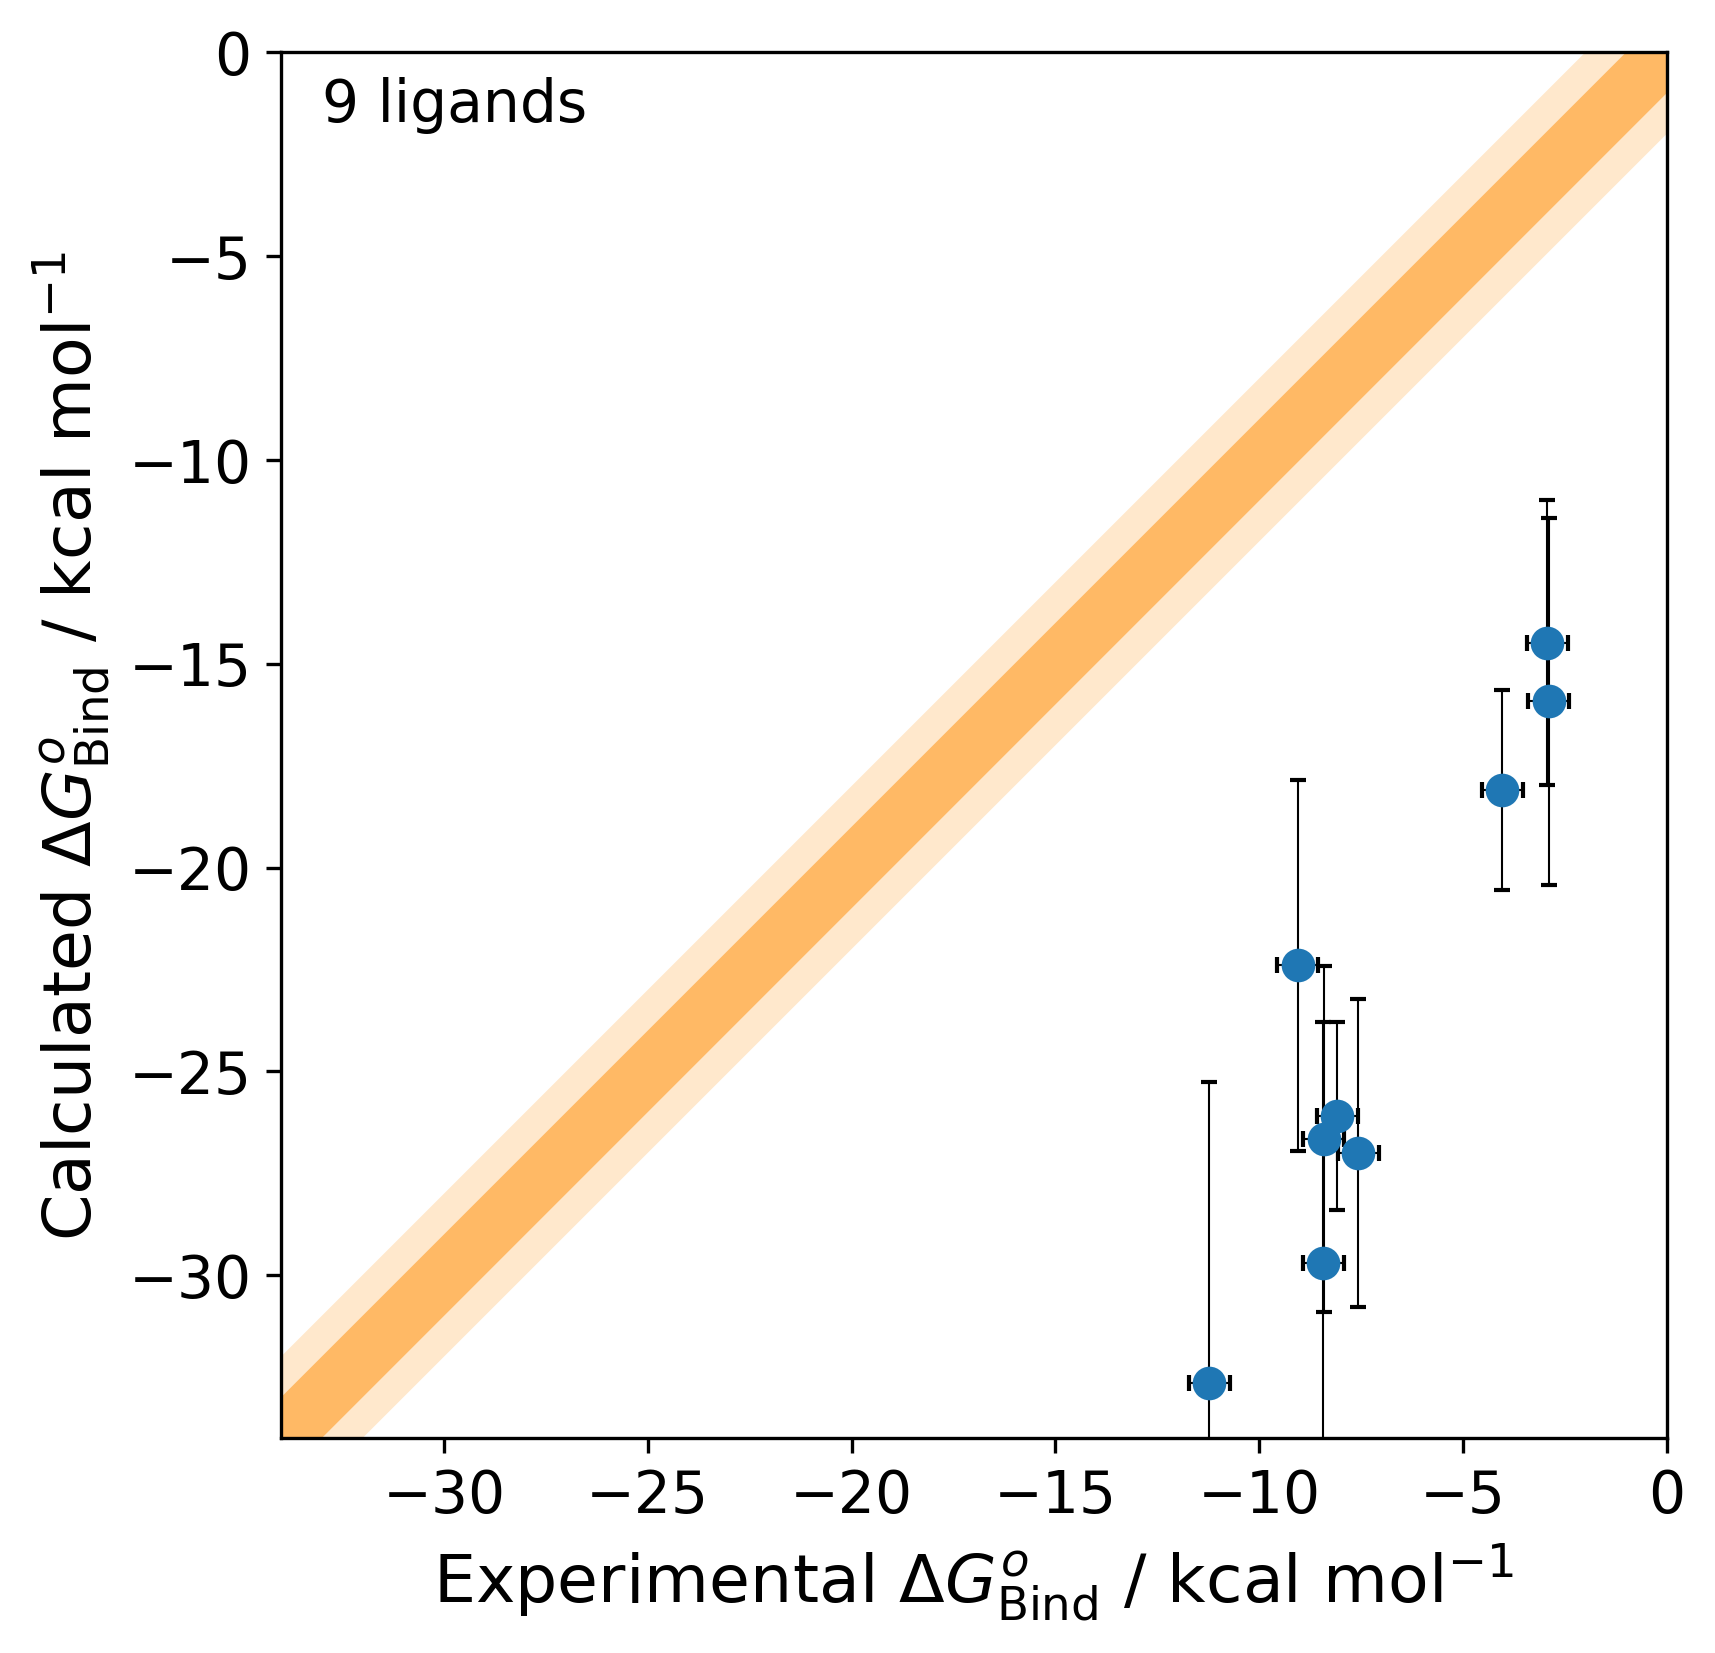

In [21]:
stats = compute_stats(dfs["0.01 ns"], n_replicates=5)
fig, ax = plot_against_exp(all_results=dfs["0.01 ns"], output_dir="output", offset=false, limits=[-34,0])
fig.savefig("output/calc_v_exp_001ns.png", dpi=300, bbox_inches="tight")

In [16]:
stats

{'r': [0.925832568262548, 0.6303948351467237, 0.9756080446449713],
 'r2': [0.8571659444556257, 0.3999761501778374, 0.9518110579806333],
 'mue': [16.70830224893486, 14.445492072418839, 19.216721726446085],
 'rmse': [17.07971241717686, 14.890732616114922, 19.70533492133825],
 'rho': [0.7666666666666667, 0.19999999999999998, 0.9333333333333332],
 'tau': [0.611111111111111, 0.1111111111111111, 0.8333333333333334]}

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


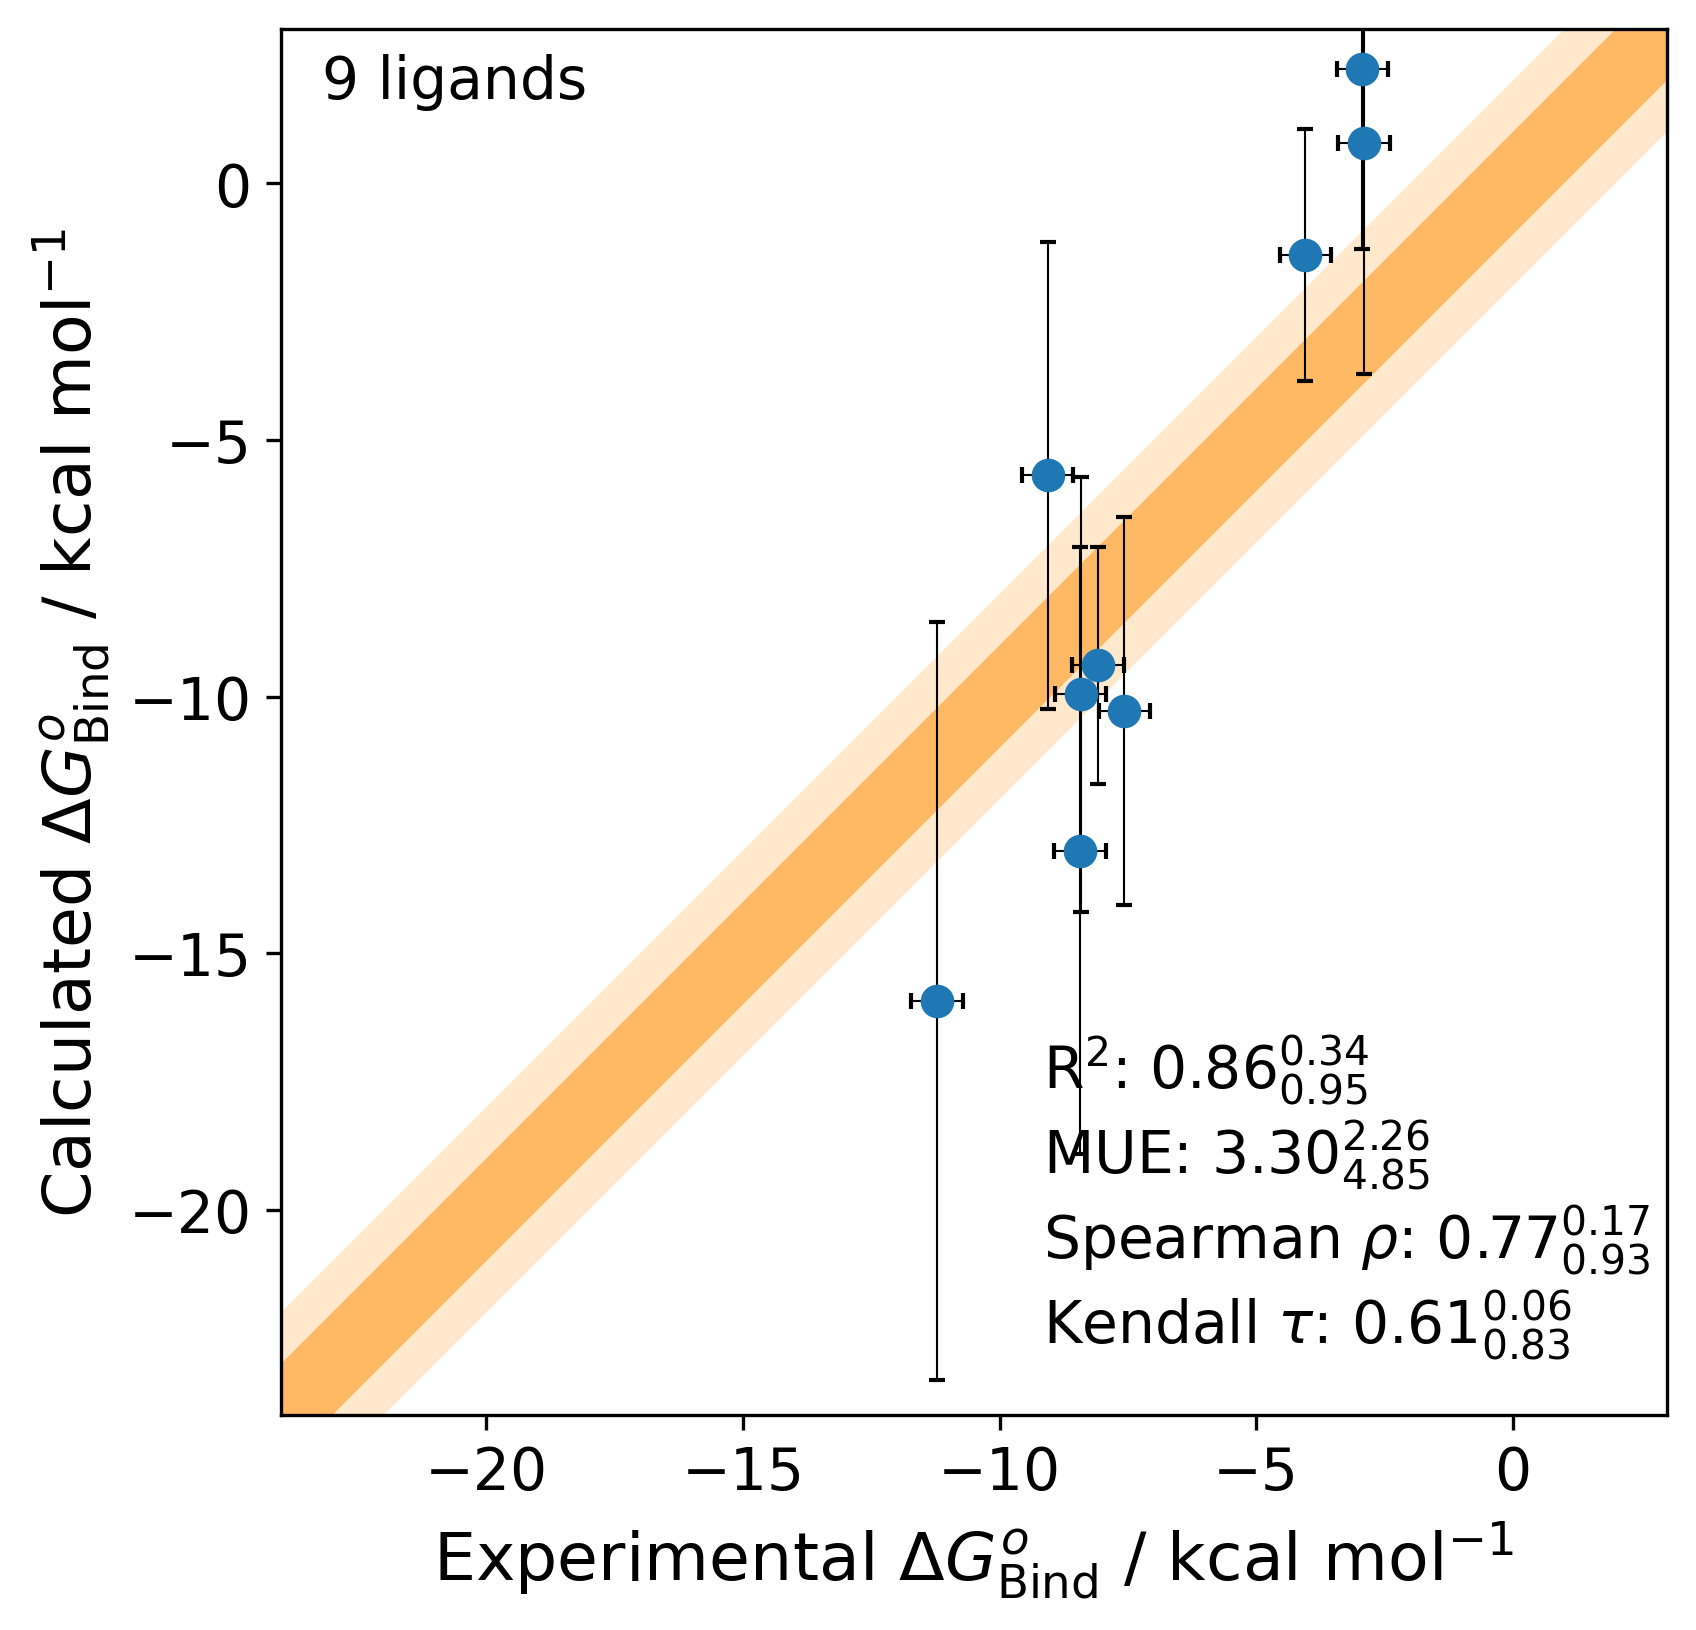

In [23]:
offset_001 =dfs["0.01 ns"].copy()
shift = offset_001["exp_dg"].mean() - offset_001["calc_dg"].mean()
offset_001["calc_dg"] += shift
stats = compute_stats(offset_001, n_replicates=5)
fig, ax = plot_against_exp(offset_001, output_dir="output", offset=True, stats=stats, limits=[-24, 3])
fig.savefig("output/calc_v_exp_001ns_offset.png", dpi=300, bbox_inches="tight")

In [74]:
stats

{'r': [0.925832568262548, 0.6104532636666423, 0.9752858076678054],
 'r2': [0.8571659444556257, 0.37265855601933506, 0.9511824067284362],
 'mue': [3.2988385118048207, 2.2658263780379495, 4.814382457553169],
 'rmse': [3.542486727103387, 2.7495389761897924, 5.728235720703088],
 'rho': [0.7666666666666667, 0.18333333333333335, 0.9333333333333332],
 'tau': [0.611111111111111, 0.1111111111111111, 0.8333333333333334]}

# 0.1 ns

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


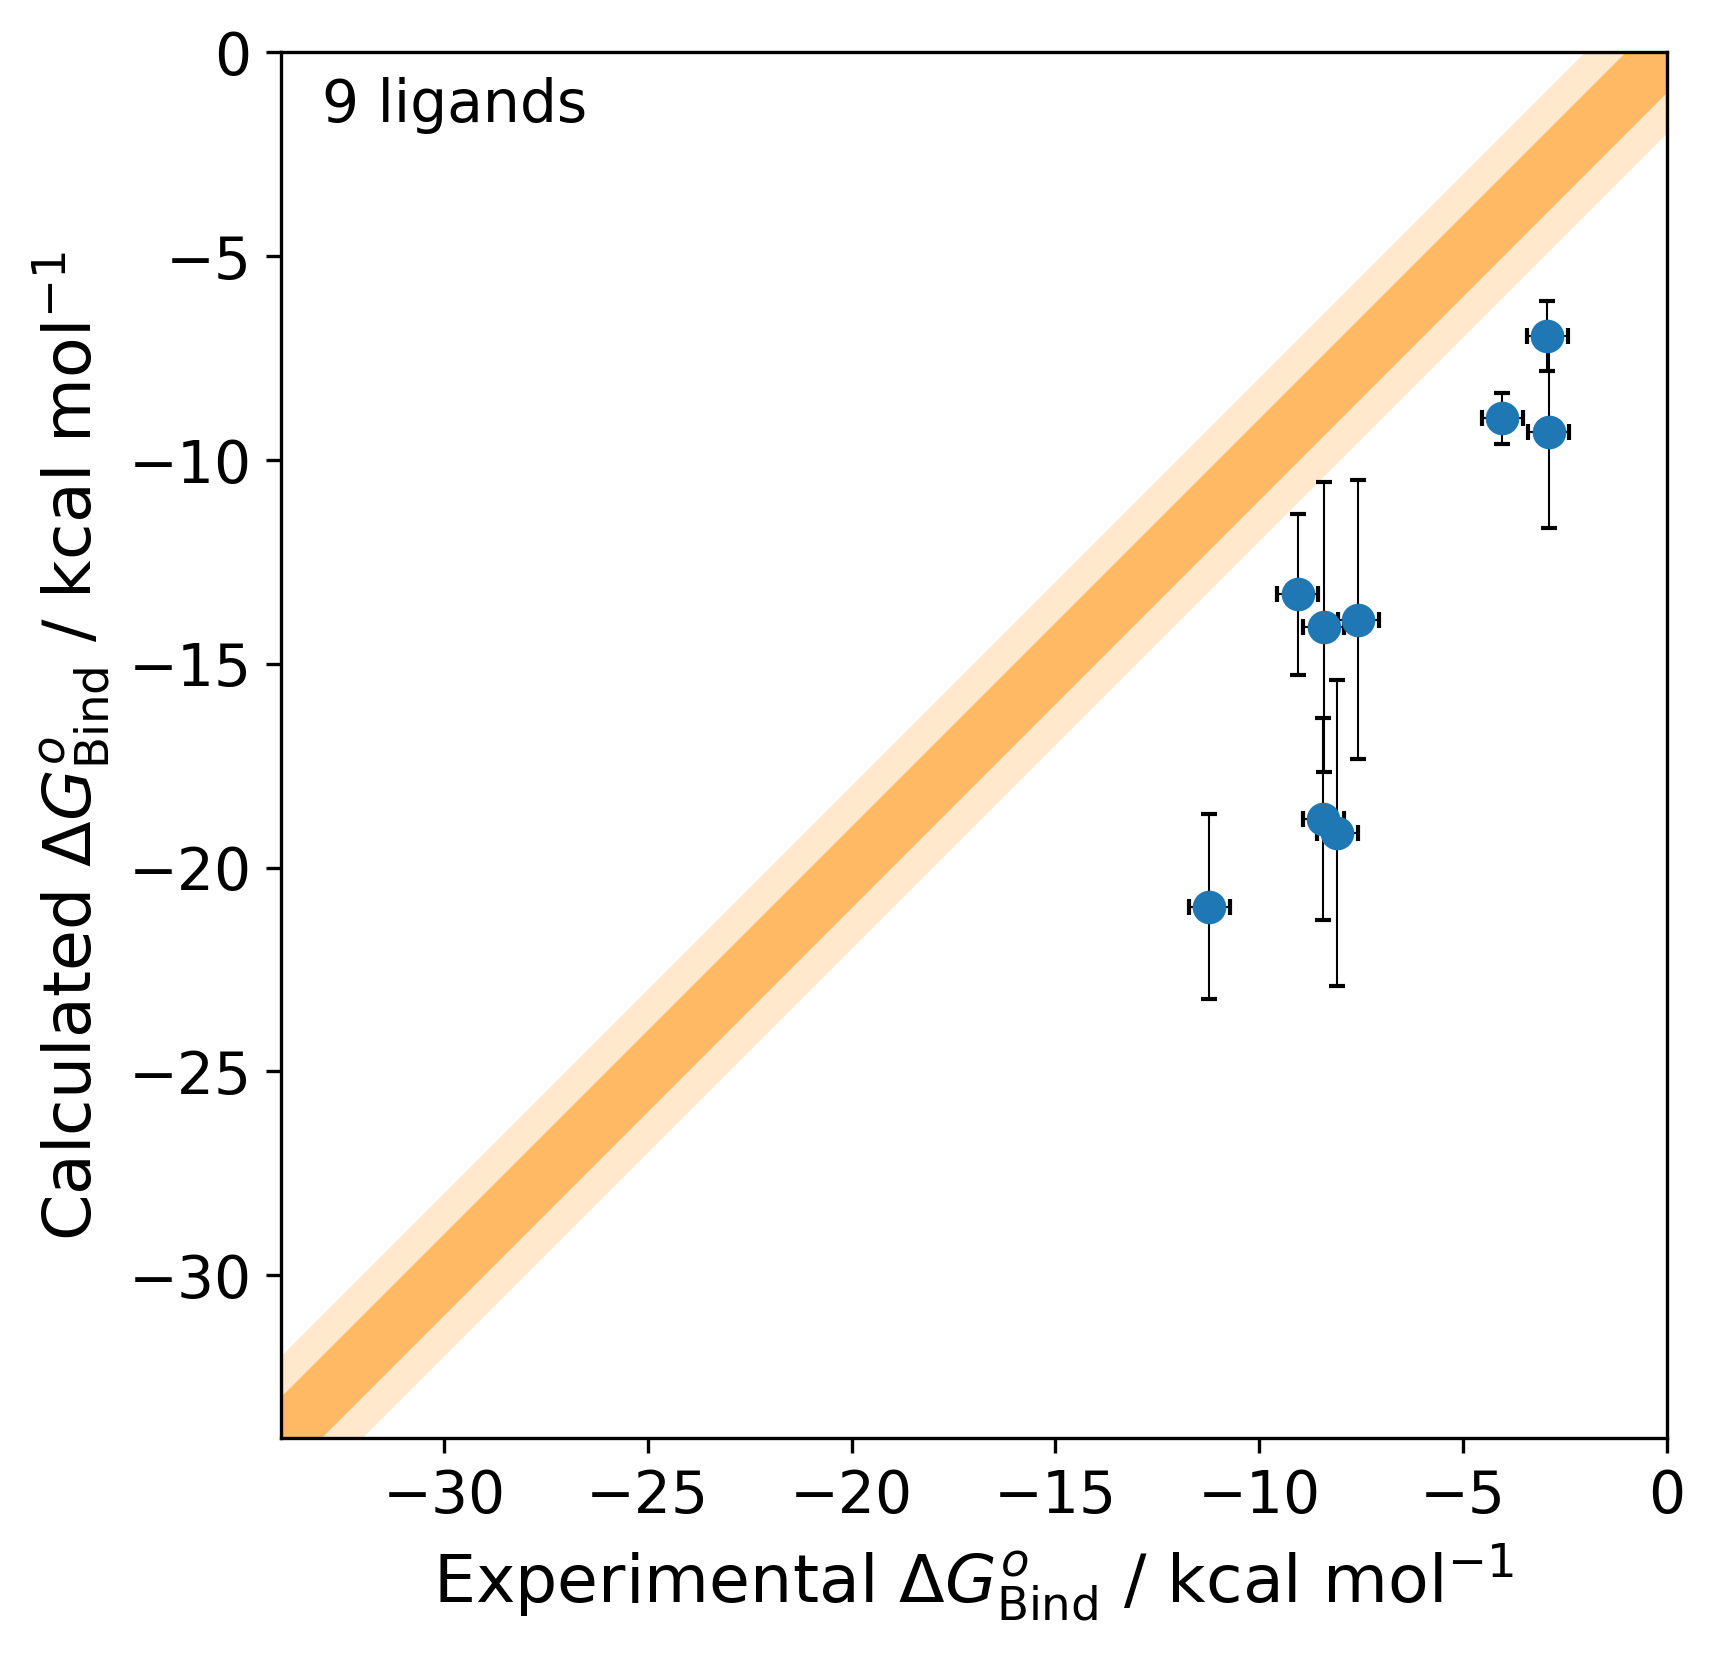

In [25]:
stats = compute_stats(dfs["0.1 ns"], n_replicates=5)
fig, ax = plot_against_exp(all_results=dfs["0.1 ns"], output_dir="output", offset=False, limits=[-34,0])
fig.savefig("output/calc_v_exp_01ns.png", dpi=300, bbox_inches="tight")


In [26]:
stats

{'r': [0.8842255465796126, 0.6275151089318418, 0.9632294808852412],
 'r2': [0.7818548172240151, 0.39967792991425777, 0.9278110350281675],
 'mue': [6.982309248934865, 5.46240910940358, 8.63374508526713],
 'rmse': [7.434312422142114, 5.822582160251855, 9.118914061062535],
 'rho': [0.7333333333333334, 0.26583333333333337, 0.9333333333333332],
 'tau': [0.5555555555555556, 0.16666666666666666, 0.8333333333333334]}

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


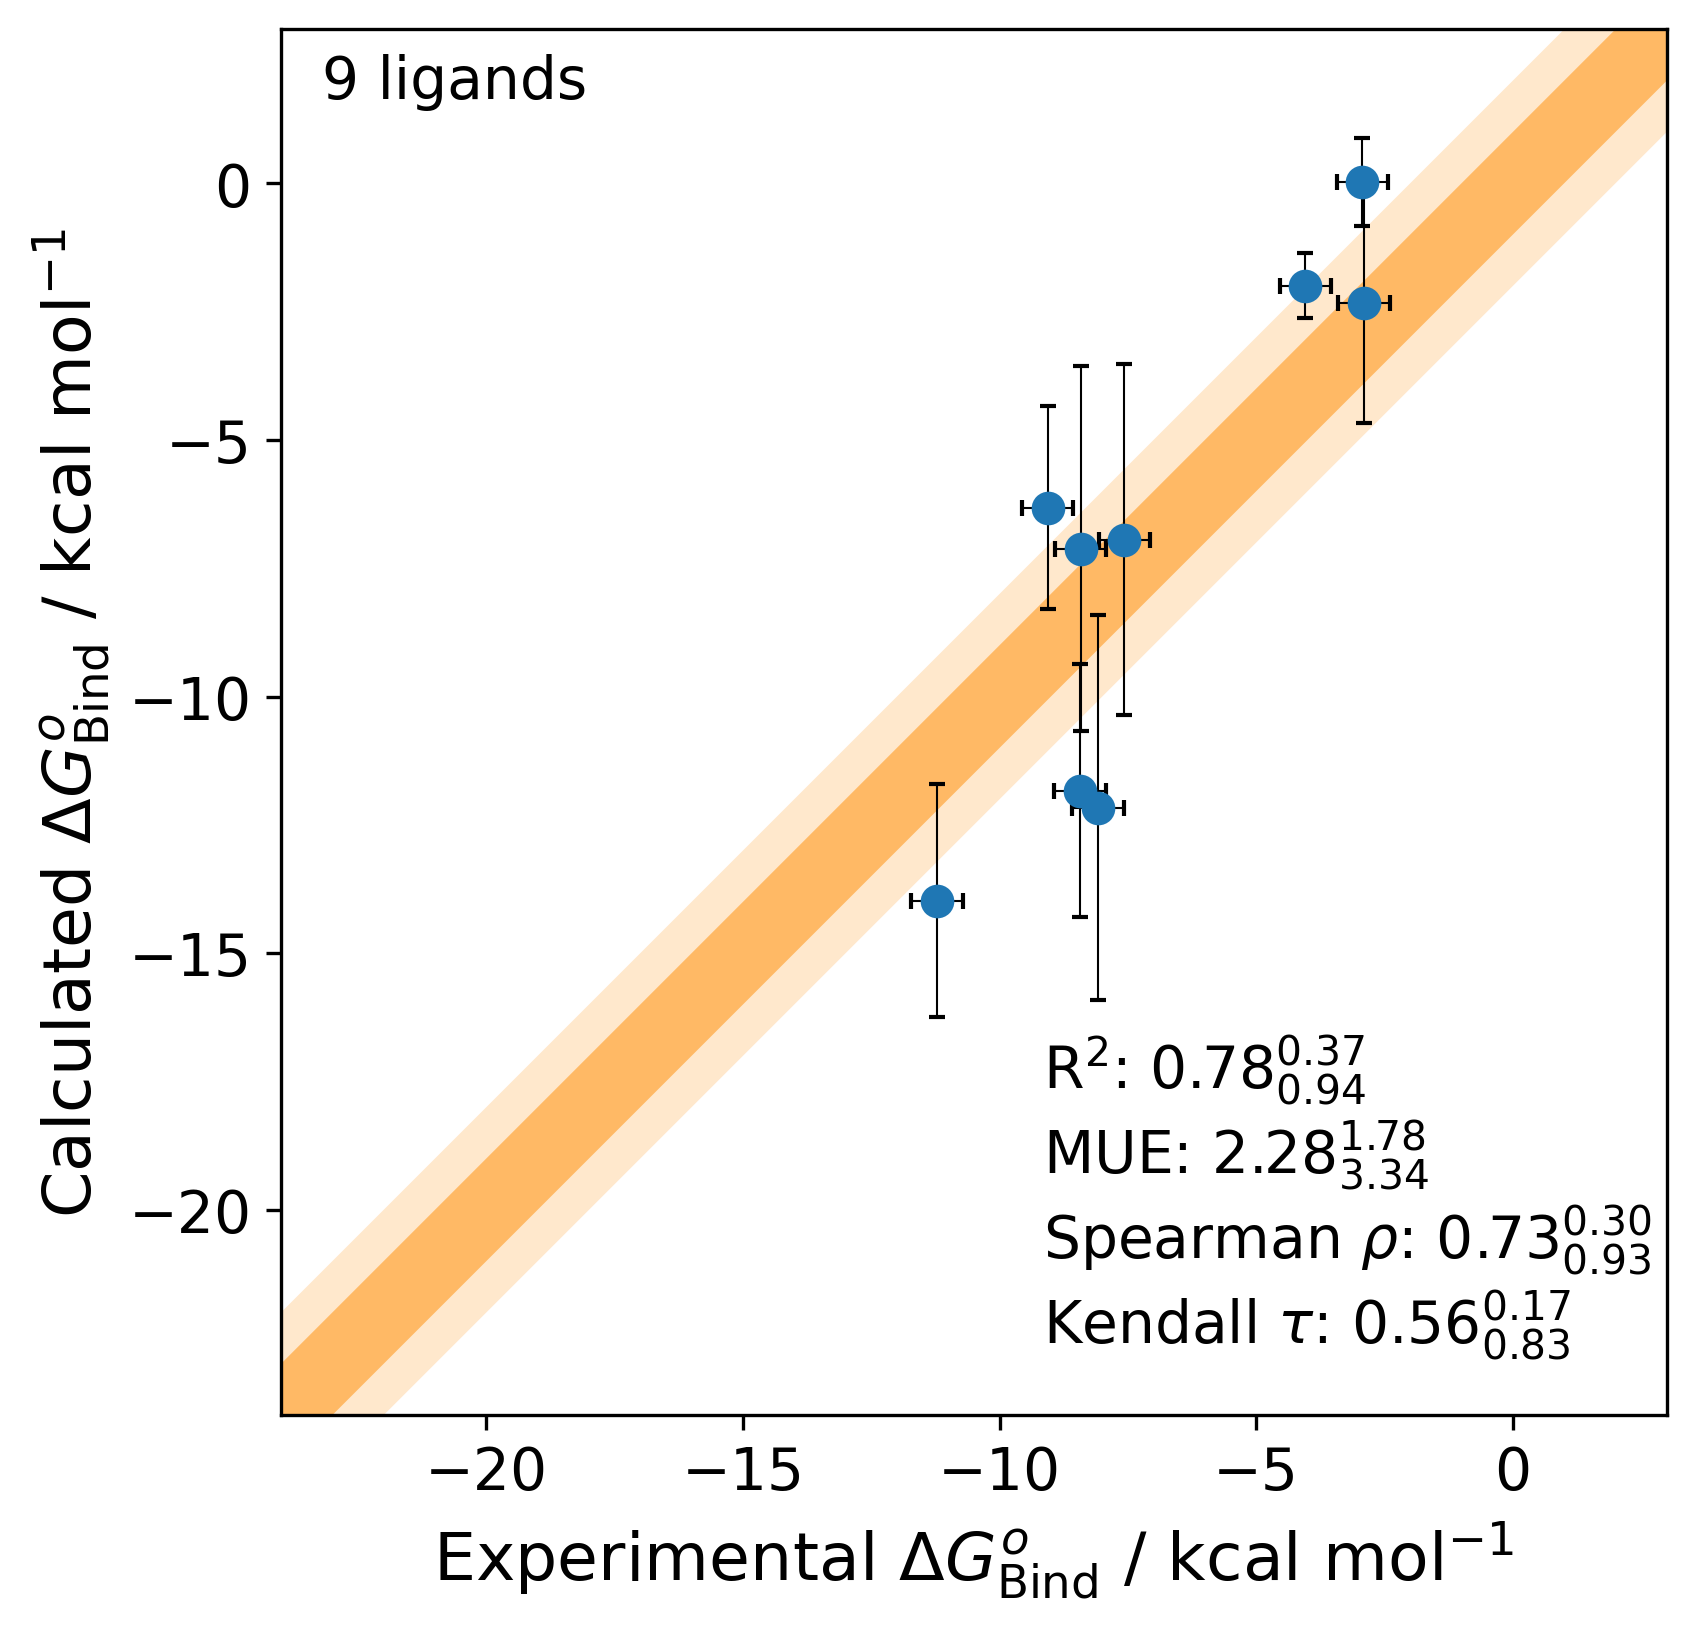

In [27]:
offset_01 =dfs["0.1 ns"].copy()
shift = offset_01["exp_dg"].mean() - offset_01["calc_dg"].mean()
offset_01["calc_dg"] += shift
stats = compute_stats(offset_01, n_replicates=5)
fig, ax = plot_against_exp(offset_01, output_dir="output", offset=true, stats=stats, limits=[-24, 3])
fig.savefig("output/calc_v_exp_01ns_offset.png", dpi=300, bbox_inches="tight")

In [28]:
stats

{'r': [0.8842255465796126, 0.6068529050269654, 0.9674033374338047],
 'r2': [0.7818548172240151, 0.3701784782185311, 0.9358692314073986],
 'mue': [2.27541604220829, 1.7847146585493134, 3.337689667011689],
 'rmse': [2.55271595408796, 2.075330307012238, 3.767647832718062],
 'rho': [0.7333333333333334, 0.3, 0.9333333333333332],
 'tau': [0.5555555555555556, 0.16666666666666666, 0.8333333333333334]}

## 5 ns

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


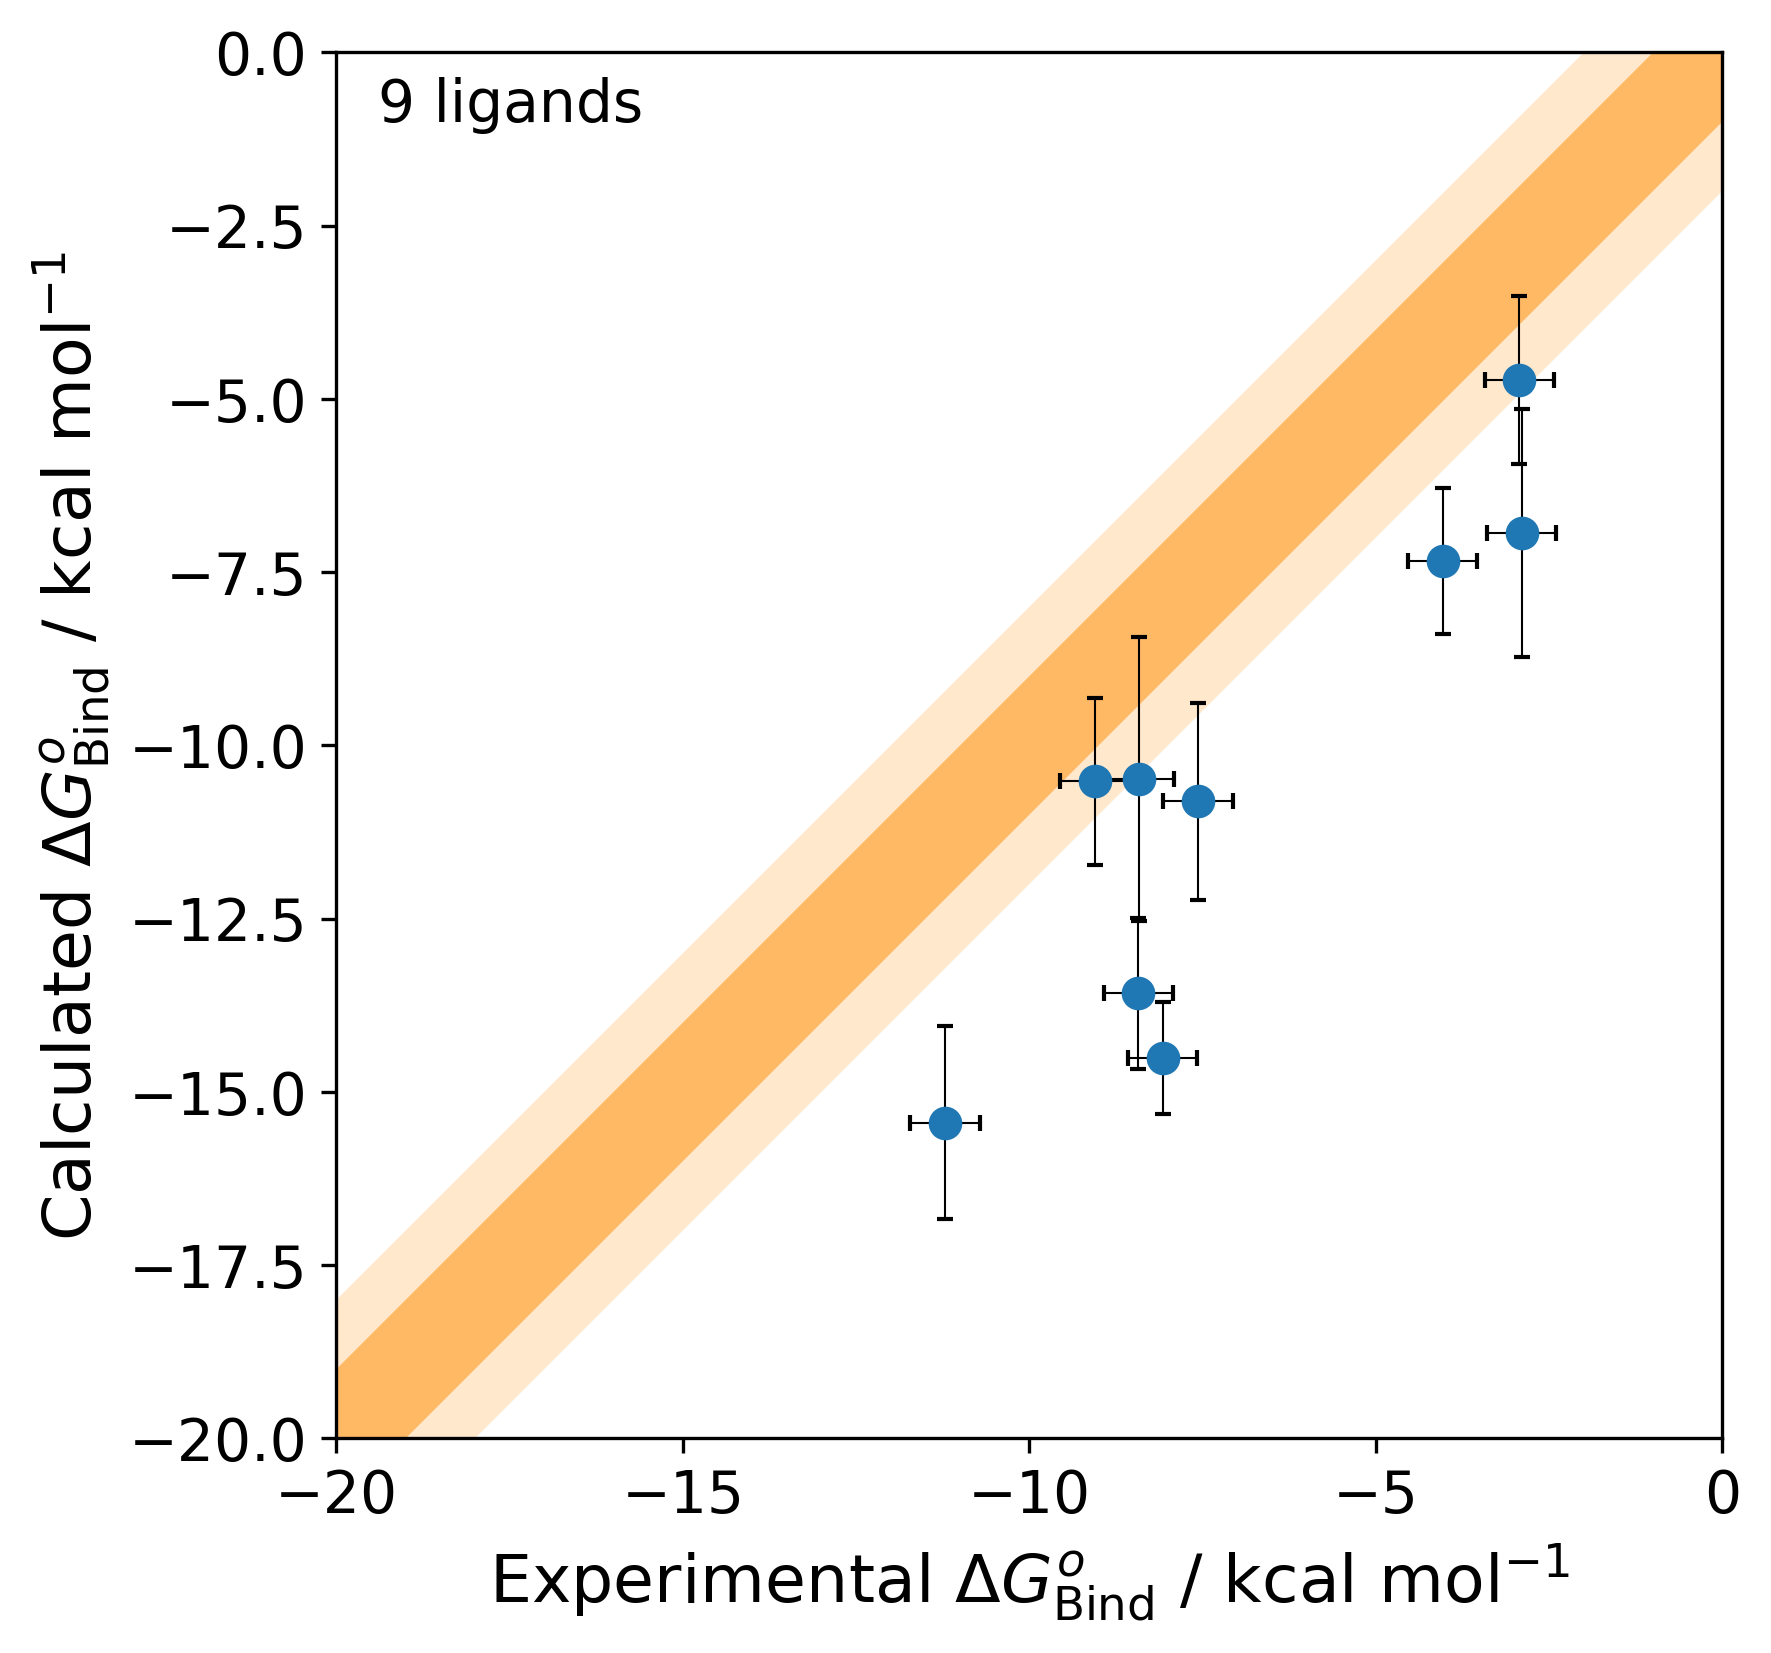

In [29]:
stats = compute_stats(dfs["5 ns"], n_replicates=5)
fig, ax = plot_against_exp(all_results=dfs["5 ns"], output_dir="output", offset=False, limits=[-20,0])
fig.savefig("output/calc_v_exp_5ns.png", dpi=300, bbox_inches="tight")


In [30]:
stats

{'r': [0.8980477532988703, 0.6834419691636645, 0.9653729372145989],
 'r2': [0.8064897672051484, 0.46709331714246505, 0.9319449201120403],
 'mue': [3.5241815378237527, 2.6512236950585555, 4.491441688496684],
 'rmse': [3.8456620543691575, 2.9769829465055815, 4.790128181078265],
 'rho': [0.7666666666666667, 0.2333333333333333, 0.9333333333333332],
 'tau': [0.611111111111111, 0.1111111111111111, 0.8333333333333334]}

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]


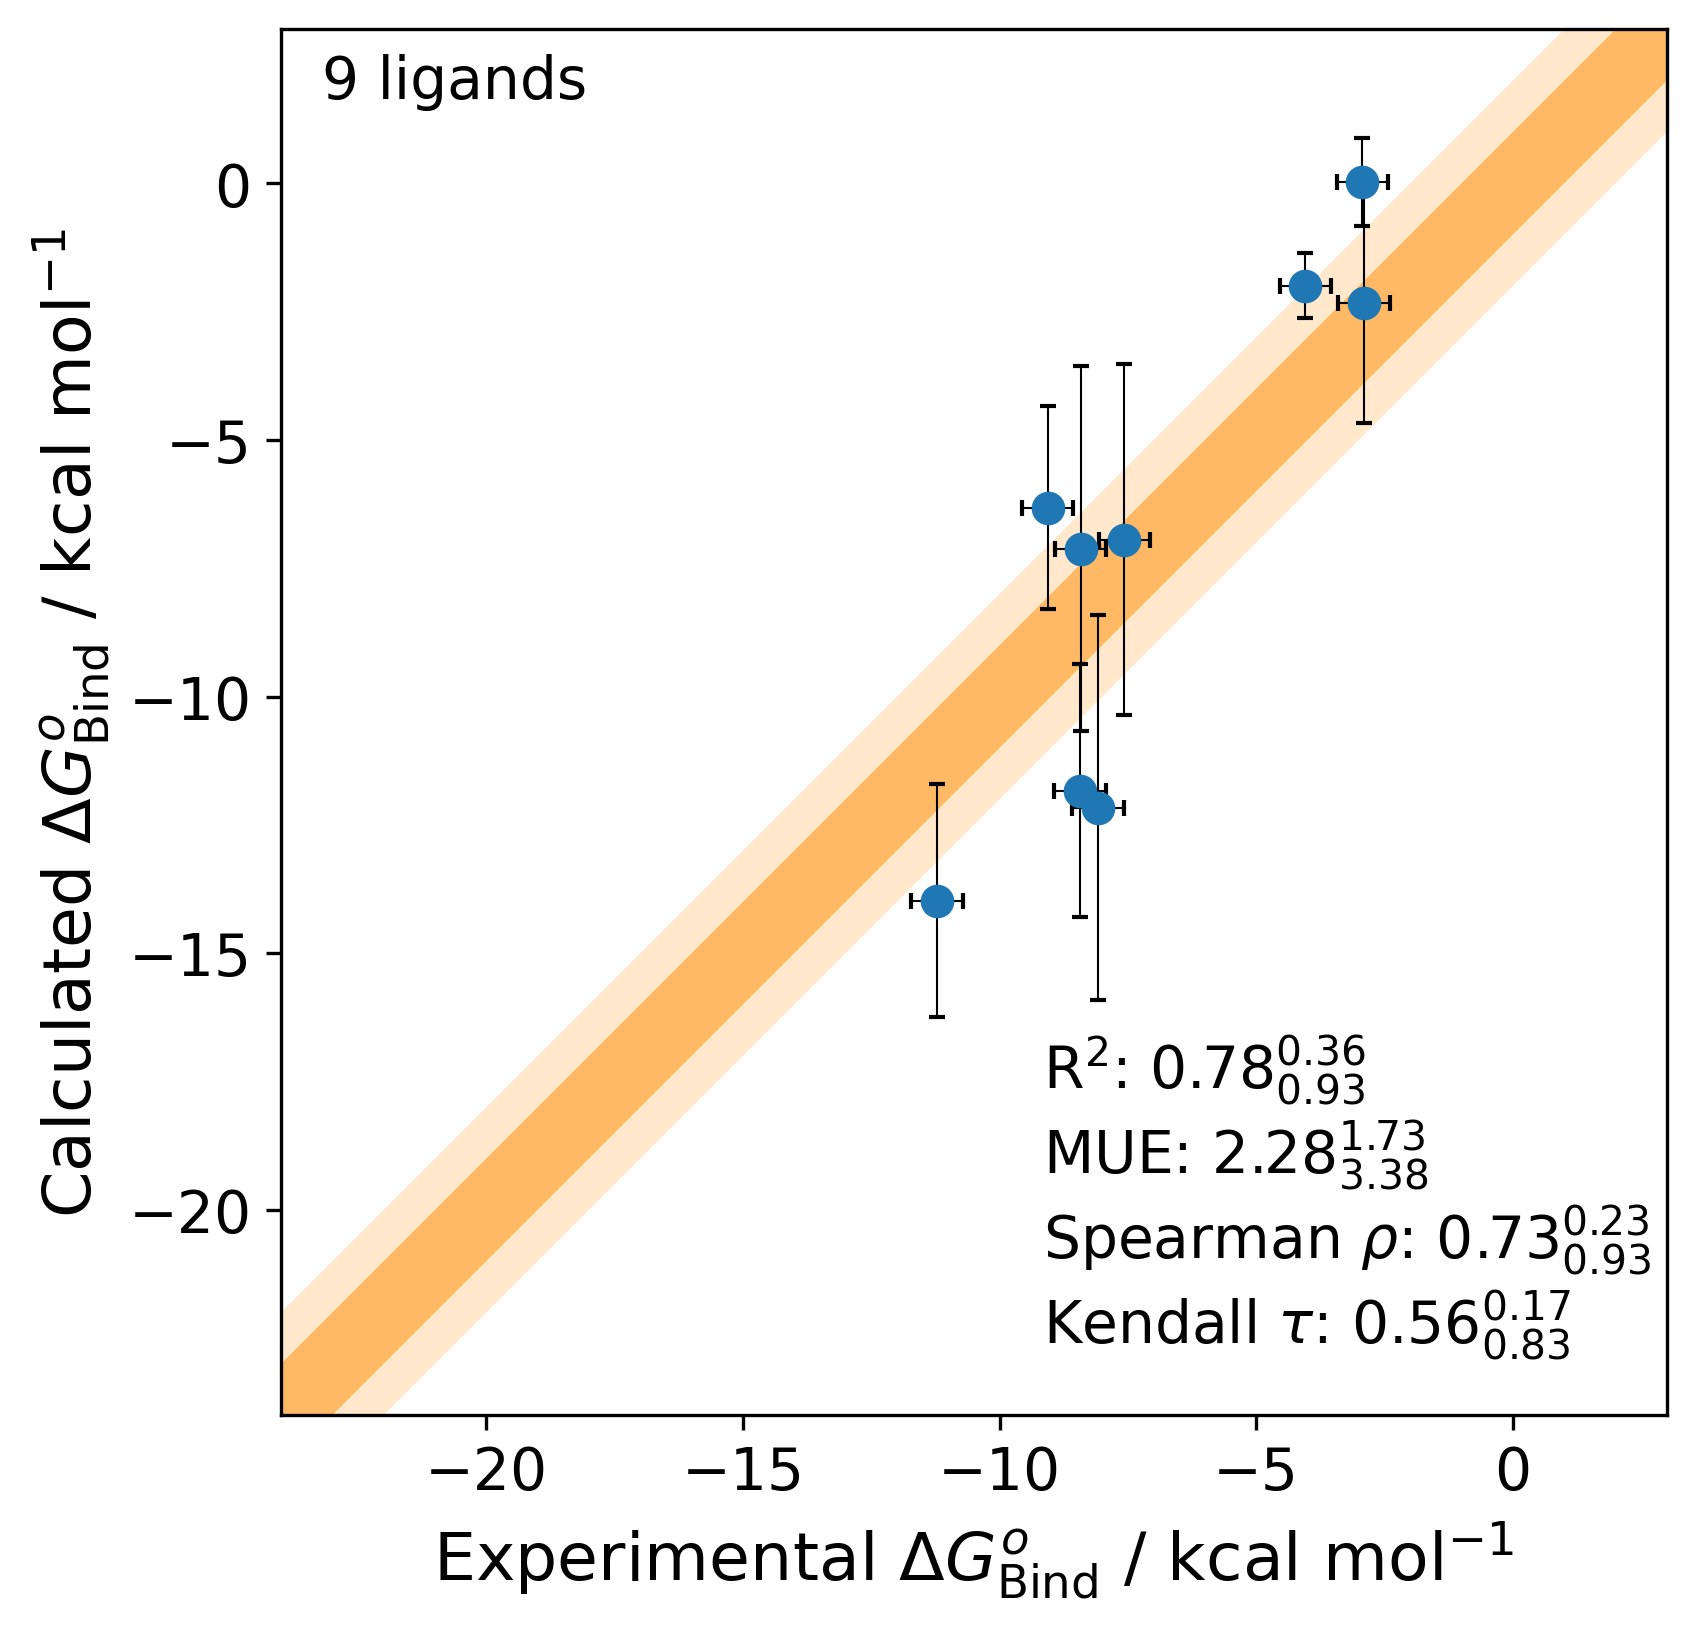

In [31]:
offset_5 =dfs["0.1 ns"].copy()
shift = offset_5["exp_dg"].mean() - offset_5["calc_dg"].mean()
offset_5["calc_dg"] += shift
stats = compute_stats(offset_5, n_replicates=5)
fig, ax = plot_against_exp(offset_5, output_dir="output", offset=True, stats=stats, limits=[-24, 3])
fig.savefig("output/calc_v_exp_5ns_offset.png", dpi=300, bbox_inches="tight")


In [32]:
stats

{'r': [0.8842255465796126, 0.599369059383549, 0.9651880066471396],
 'r2': [0.7818548172240151, 0.36288425012790587, 0.9315879461079489],
 'mue': [2.27541604220829, 1.7278556459152044, 3.3784624728127888],
 'rmse': [2.55271595408796, 2.005673378646912, 3.8008047995884544],
 'rho': [0.7333333333333334, 0.2333333333333333, 0.9333333333333332],
 'tau': [0.5555555555555556, 0.16666666666666666, 0.8333333333333334]}

## Plot All Correlations on Single Plot

In [104]:
import seaborn as sns
sns.set_palette("viridis", n_colors=3)

def plot_against_exp_multi(
    ax,
    all_results: _pd.DataFrame,
    output_dir: str,
    offset: bool = False,
    stats: _Optional[_Dict] = None,
    limits = [-24,0],
    name="",
    color=None,
) -> None:
    """
    Plot all results from a set of calculations against the
    experimental values.

    Parameters
    ----------
    all_results : _pd.DataFrame
        A DataFrame containing the experimental and calculated
        free energy changes and errors.
    output_dir : str
        Directory to save the plot to.
    offset: bool, Optional, Default = False
        Whether the calculated absolute binding free energies have been
        offset so that the mean experimental and calculated values are the same.
    stats: Dict, Optional, Default = None
        A dictionary of statistics, obtained using analyse.analyse_set.compute_stats
    """
    # Check that the correct columns have been supplied
    required_columns = [
        "calc_base_dir",
        "exp_dg",
        "exp_er",
        "calc_cor",
        "calc_dg",
        "calc_er",
    ]
    # Check that all_results.columns is a superset of required_columns
    if not set(all_results.columns).issuperset(required_columns):
        raise ValueError(
            f"The experimental values file must have the columns {required_columns} but has the columns {all_results.columns}"
        )

    ax.errorbar(
        x=all_results["exp_dg"],
        y=all_results["calc_dg"],
        xerr=all_results["exp_er"],
        yerr=all_results["calc_er"],
        ls="none",
        capsize=2,
        lw=0.5,
        alpha=0.8,
        color=color
    )
    # Use seaborn colors

    ax.scatter(x=all_results["exp_dg"], y=all_results["calc_dg"], s=50, zorder=100, label=name, alpha=0.8, color=color)
    ax.set_ylim([limits[0], limits[1]])
    ax.set_xlim([limits[0], limits[1]])
    ax.set_aspect("equal")
    ax.set_xlabel(r"Experimental $\Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
    ax.set_ylabel(r"Calculated $\Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
    
    # Add text, including number of ligands and stats if supplied
    n_ligs = len(all_results["calc_dg"])
    ax.text(0.03, 0.95, f"{n_ligs} ligands", transform=ax.transAxes)
    if stats:
        stats_text = ""
        for stat, label in zip(
            ["r2", "mue", "rho", "tau"],
            ["R$^2$", "MUE", r"Spearman $\rho$", r"Kendall $\tau$"],
        ):
            stats_text += f"{label}: {stats[stat][0]:.2f}$^{{{stats[stat][1]:.2f}}}_{{{stats[stat][2]:.2f}}}$\n"
        ax.text(0.55, 0, stats_text, transform=ax.transAxes)

def add_centre_lines(ax):
    # 1 kcal mol-1
    ax.fill_between(
        x=[-35, 4],
        y2=[-34, 5],
        y1=[-36, 3],
        lw=0,
        zorder=-10,
        alpha=0.5,
        color="darkgrey",
    )
    # 2 kcal mol-1
    ax.fill_between(
        x=[-35, 4],
        y2=[-33, 6],
        y1=[-37, 2],
        lw=0,
        color="darkgrey",
        alpha=0.2,
    )


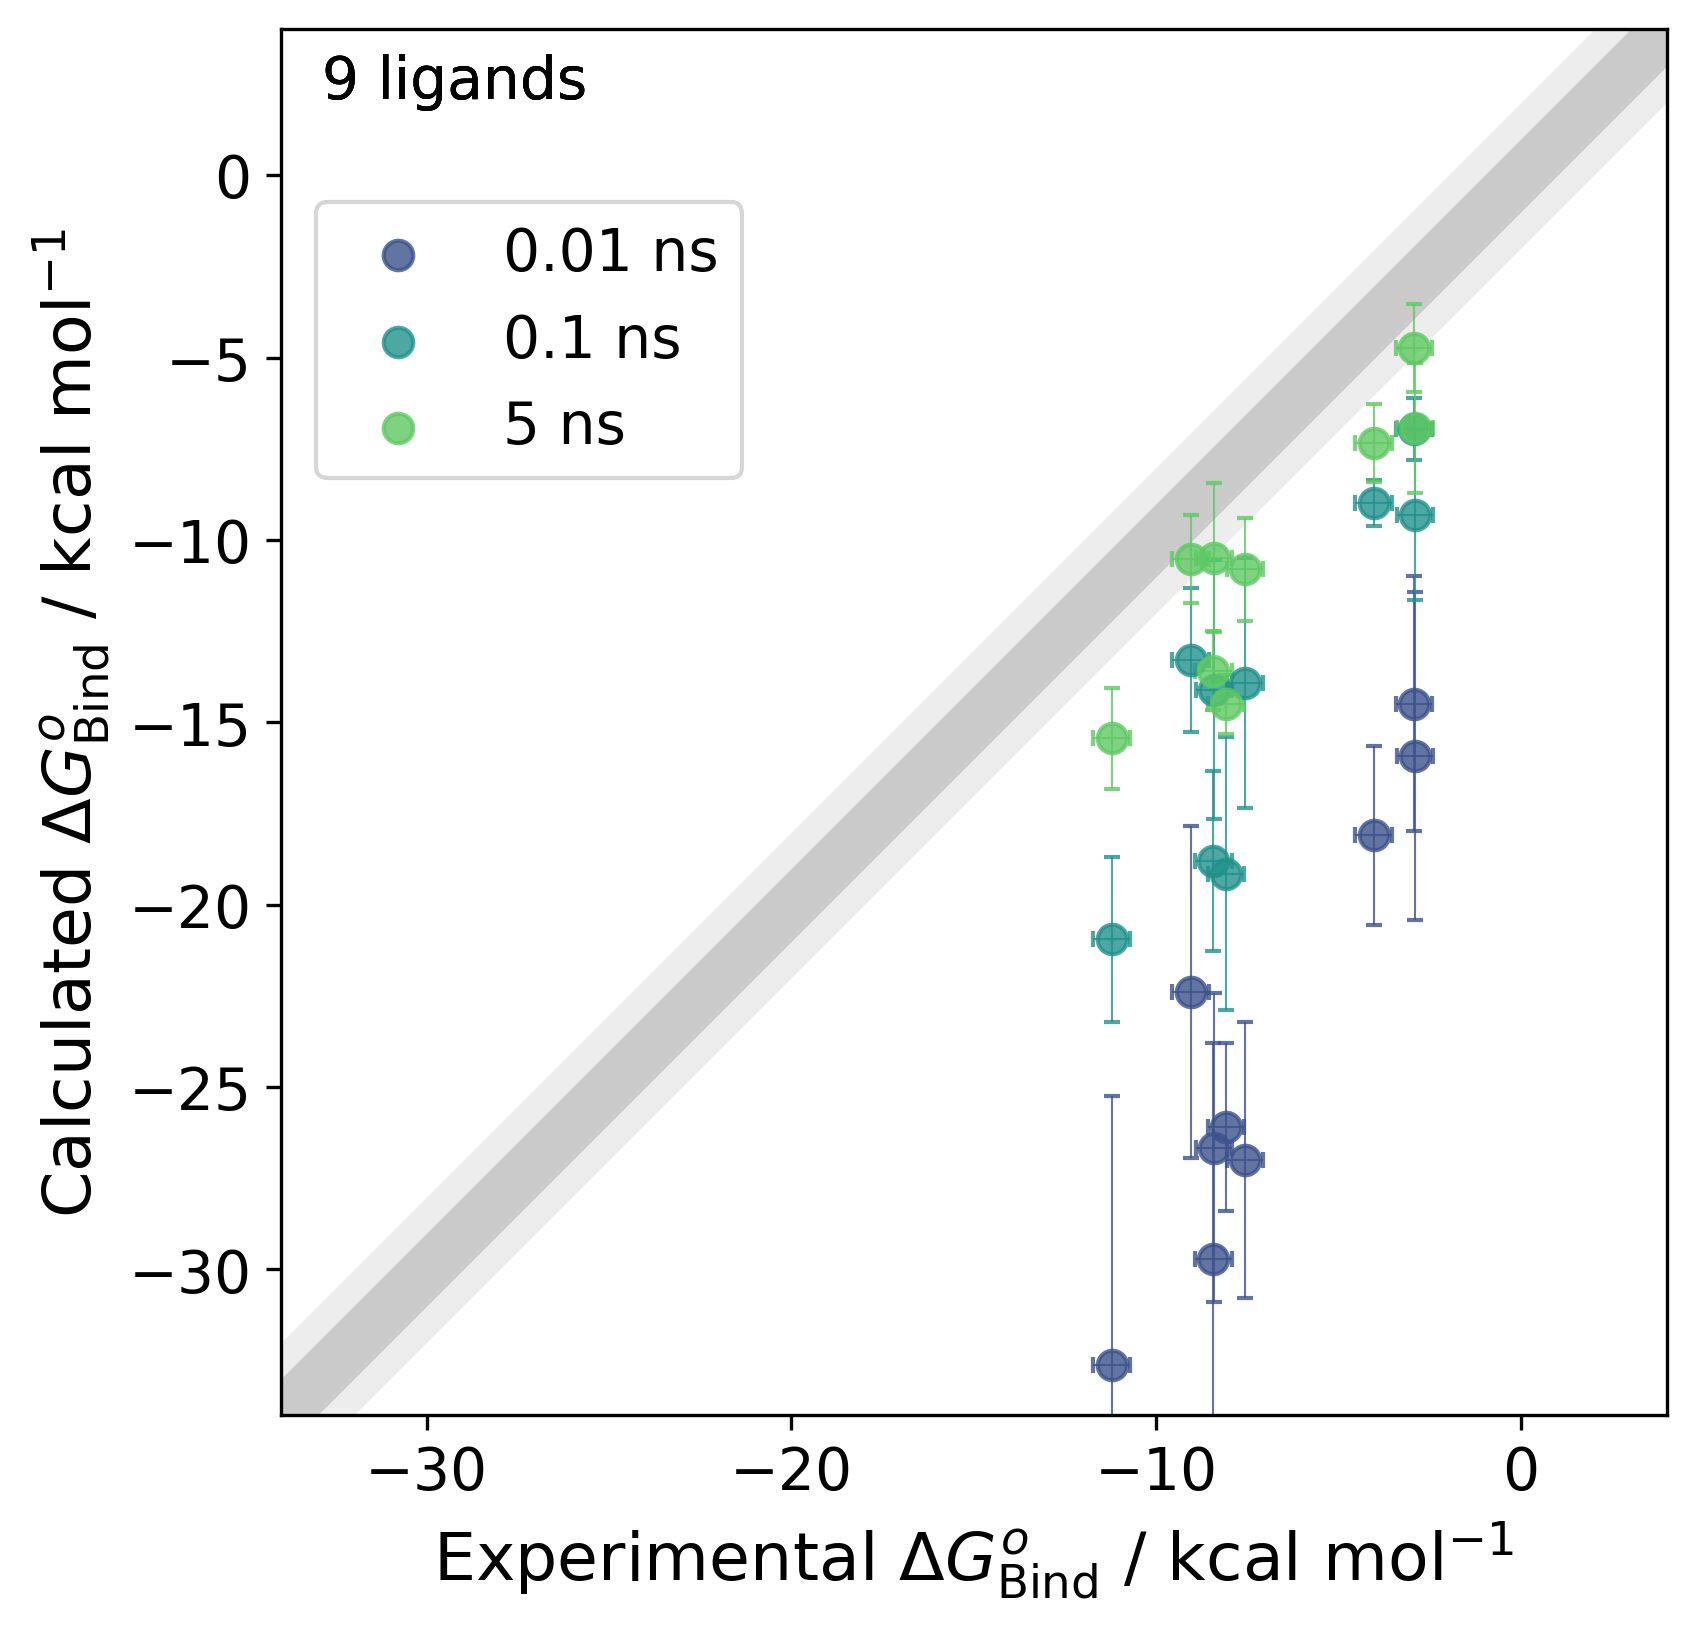

In [96]:
# Plot without offsetting
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
add_centre_lines(ax)
for name in dfs:
    plot_against_exp_multi(ax=ax, all_results=dfs[name], output_dir="output", offset=False, limits=[-34, 4], name=name)

fig.legend(bbox_to_anchor=(0.4,0.8))
fig.savefig("output/all_times_to_exp", dpi=300, bbox_inches="tight")

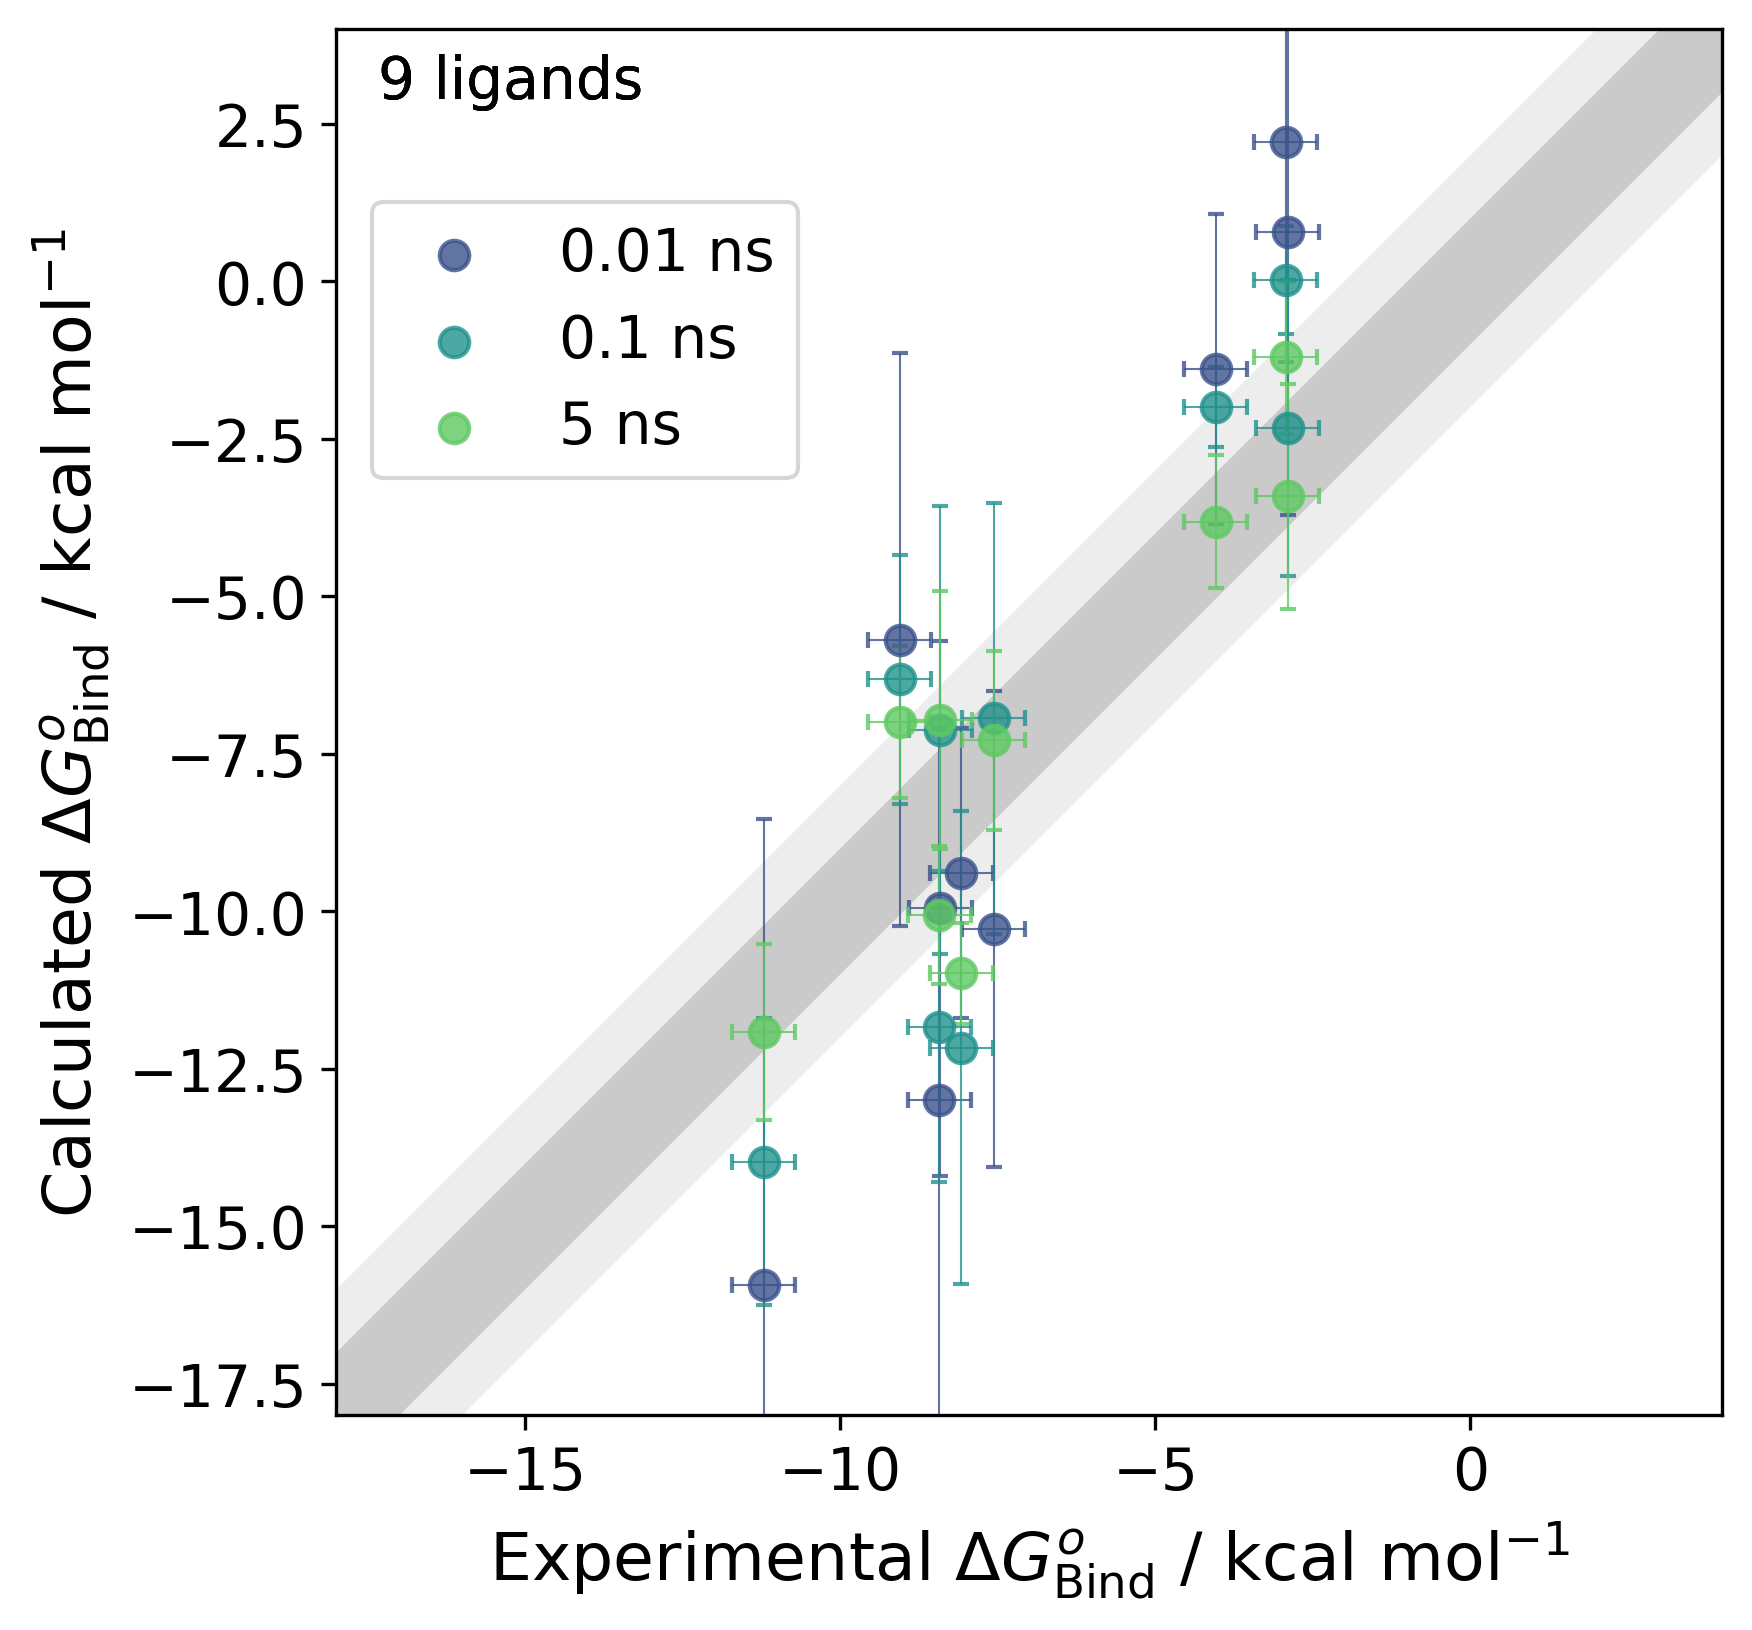

In [105]:
# Plot with offsetting
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
add_centre_lines(ax)
for name in dfs:
    offset_res =dfs[name].copy()
    shift = offset_res["exp_dg"].mean() - offset_res["calc_dg"].mean()
    offset_res["calc_dg"] += shift
    plot_against_exp_multi(ax=ax, all_results=offset_res, output_dir="output", offset=True, limits=[-18, 4], name=name)

fig.legend(bbox_to_anchor=(0.4,0.8))
fig.savefig("output/all_times_to_exp_offset", dpi=300, bbox_inches="tight")

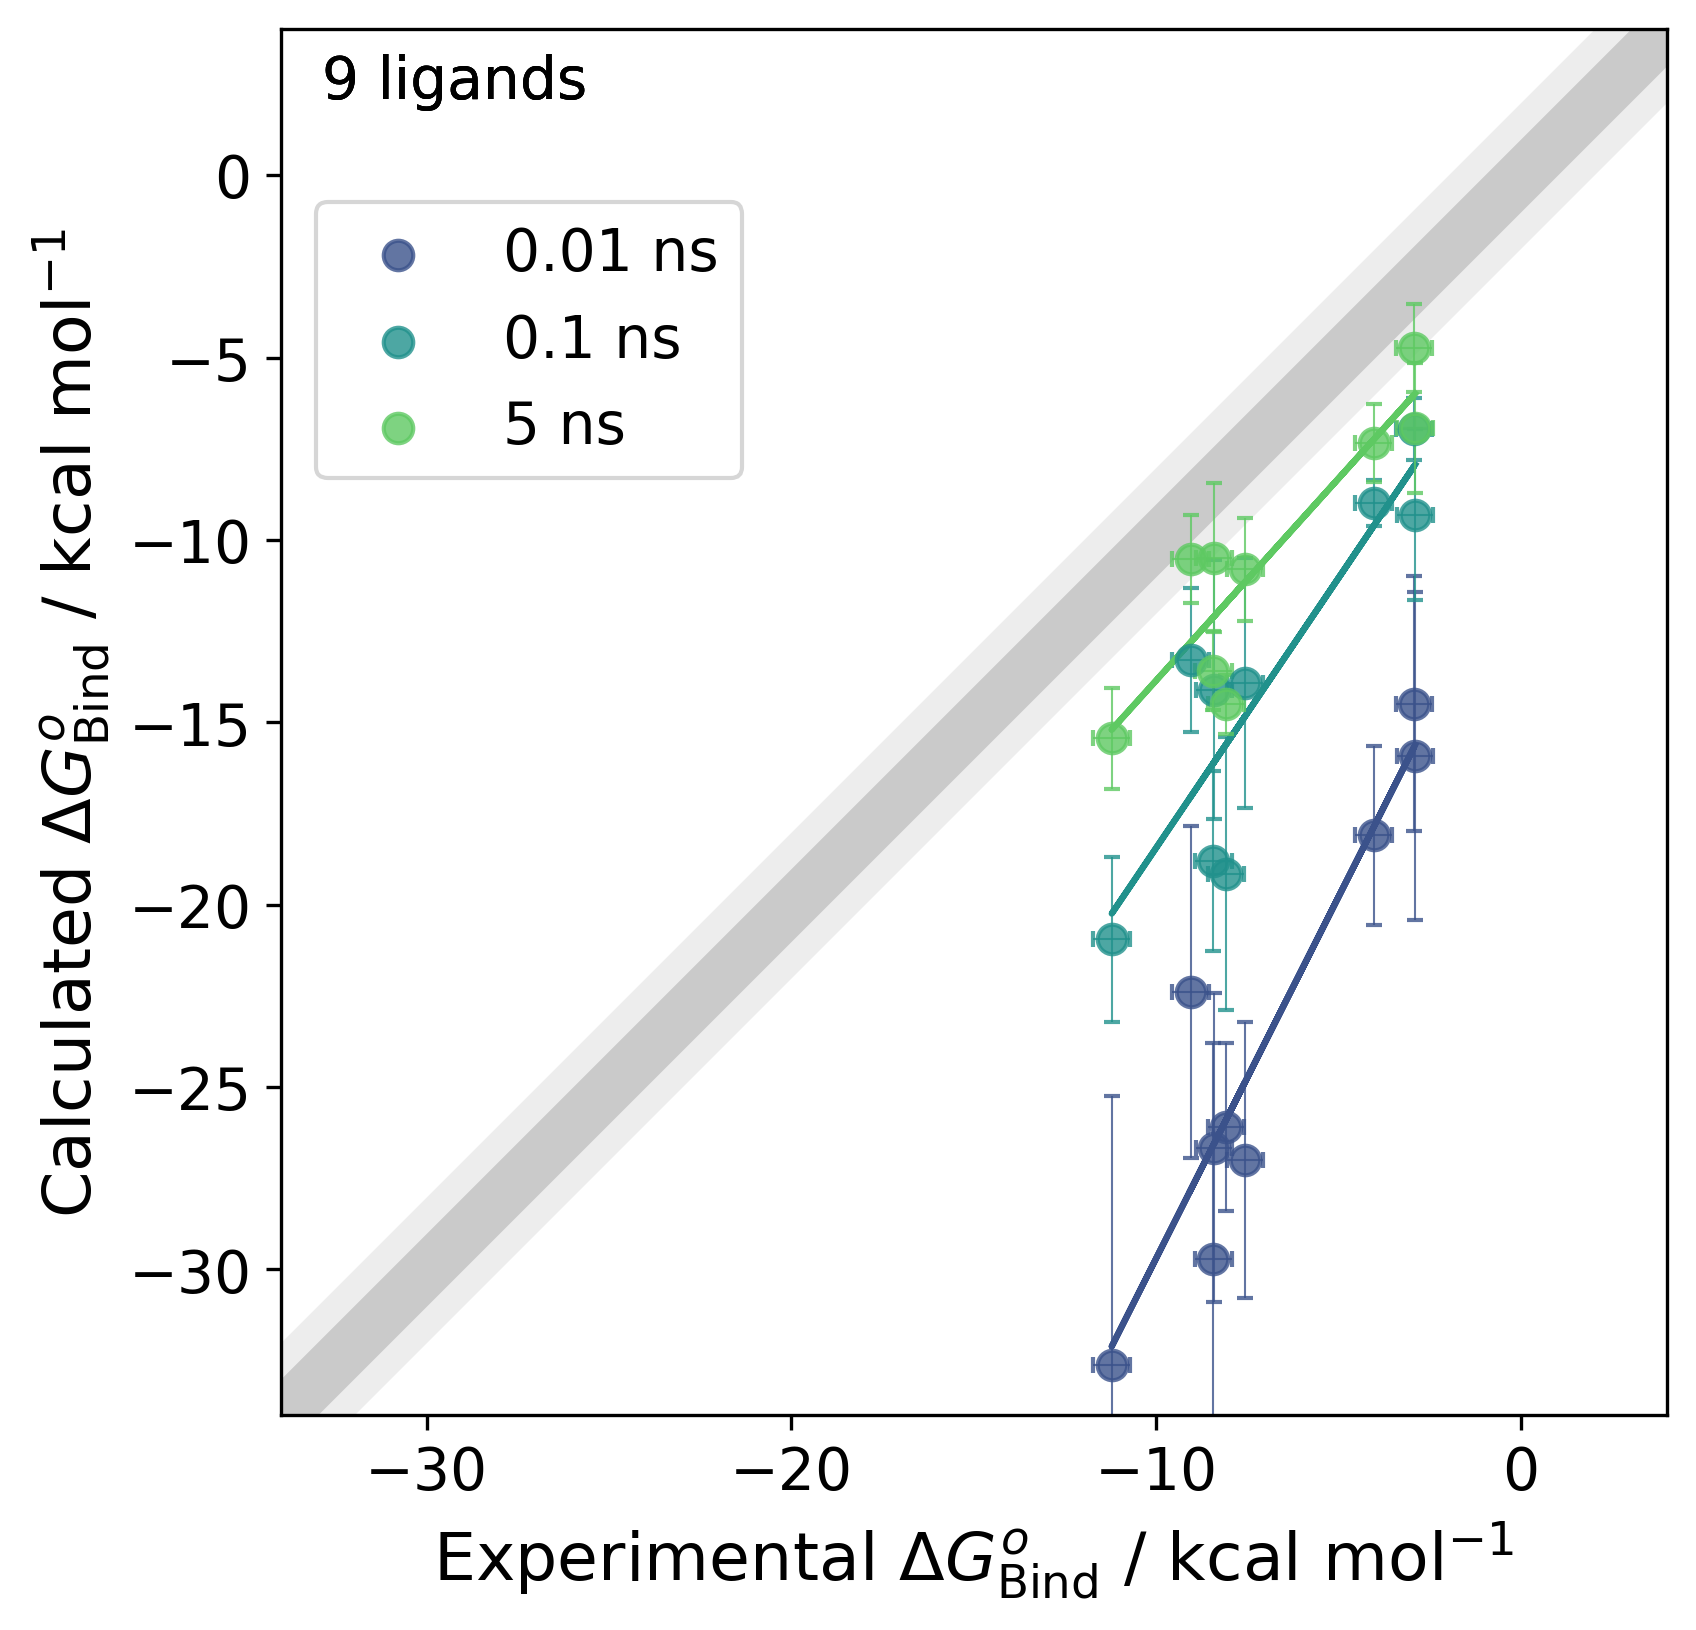

In [109]:
from scipy import stats

colors = sns.color_palette("viridis", n_colors=3)

fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
add_centre_lines(ax)
for i, name in enumerate(dfs):
    plot_against_exp_multi(ax=ax, all_results=dfs[name], output_dir="output", offset=False, limits=[-34, 4], name=name, color=colors[i])
    # Add line of best fit
    x = dfs[name]["exp_dg"]
    y = dfs[name]["calc_dg"]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(x, intercept + slope*x, color=colors[i])

fig.legend(bbox_to_anchor=(0.4,0.8))
fig.savefig("output/all_times_to_exp_lines", dpi=300, bbox_inches="tight")

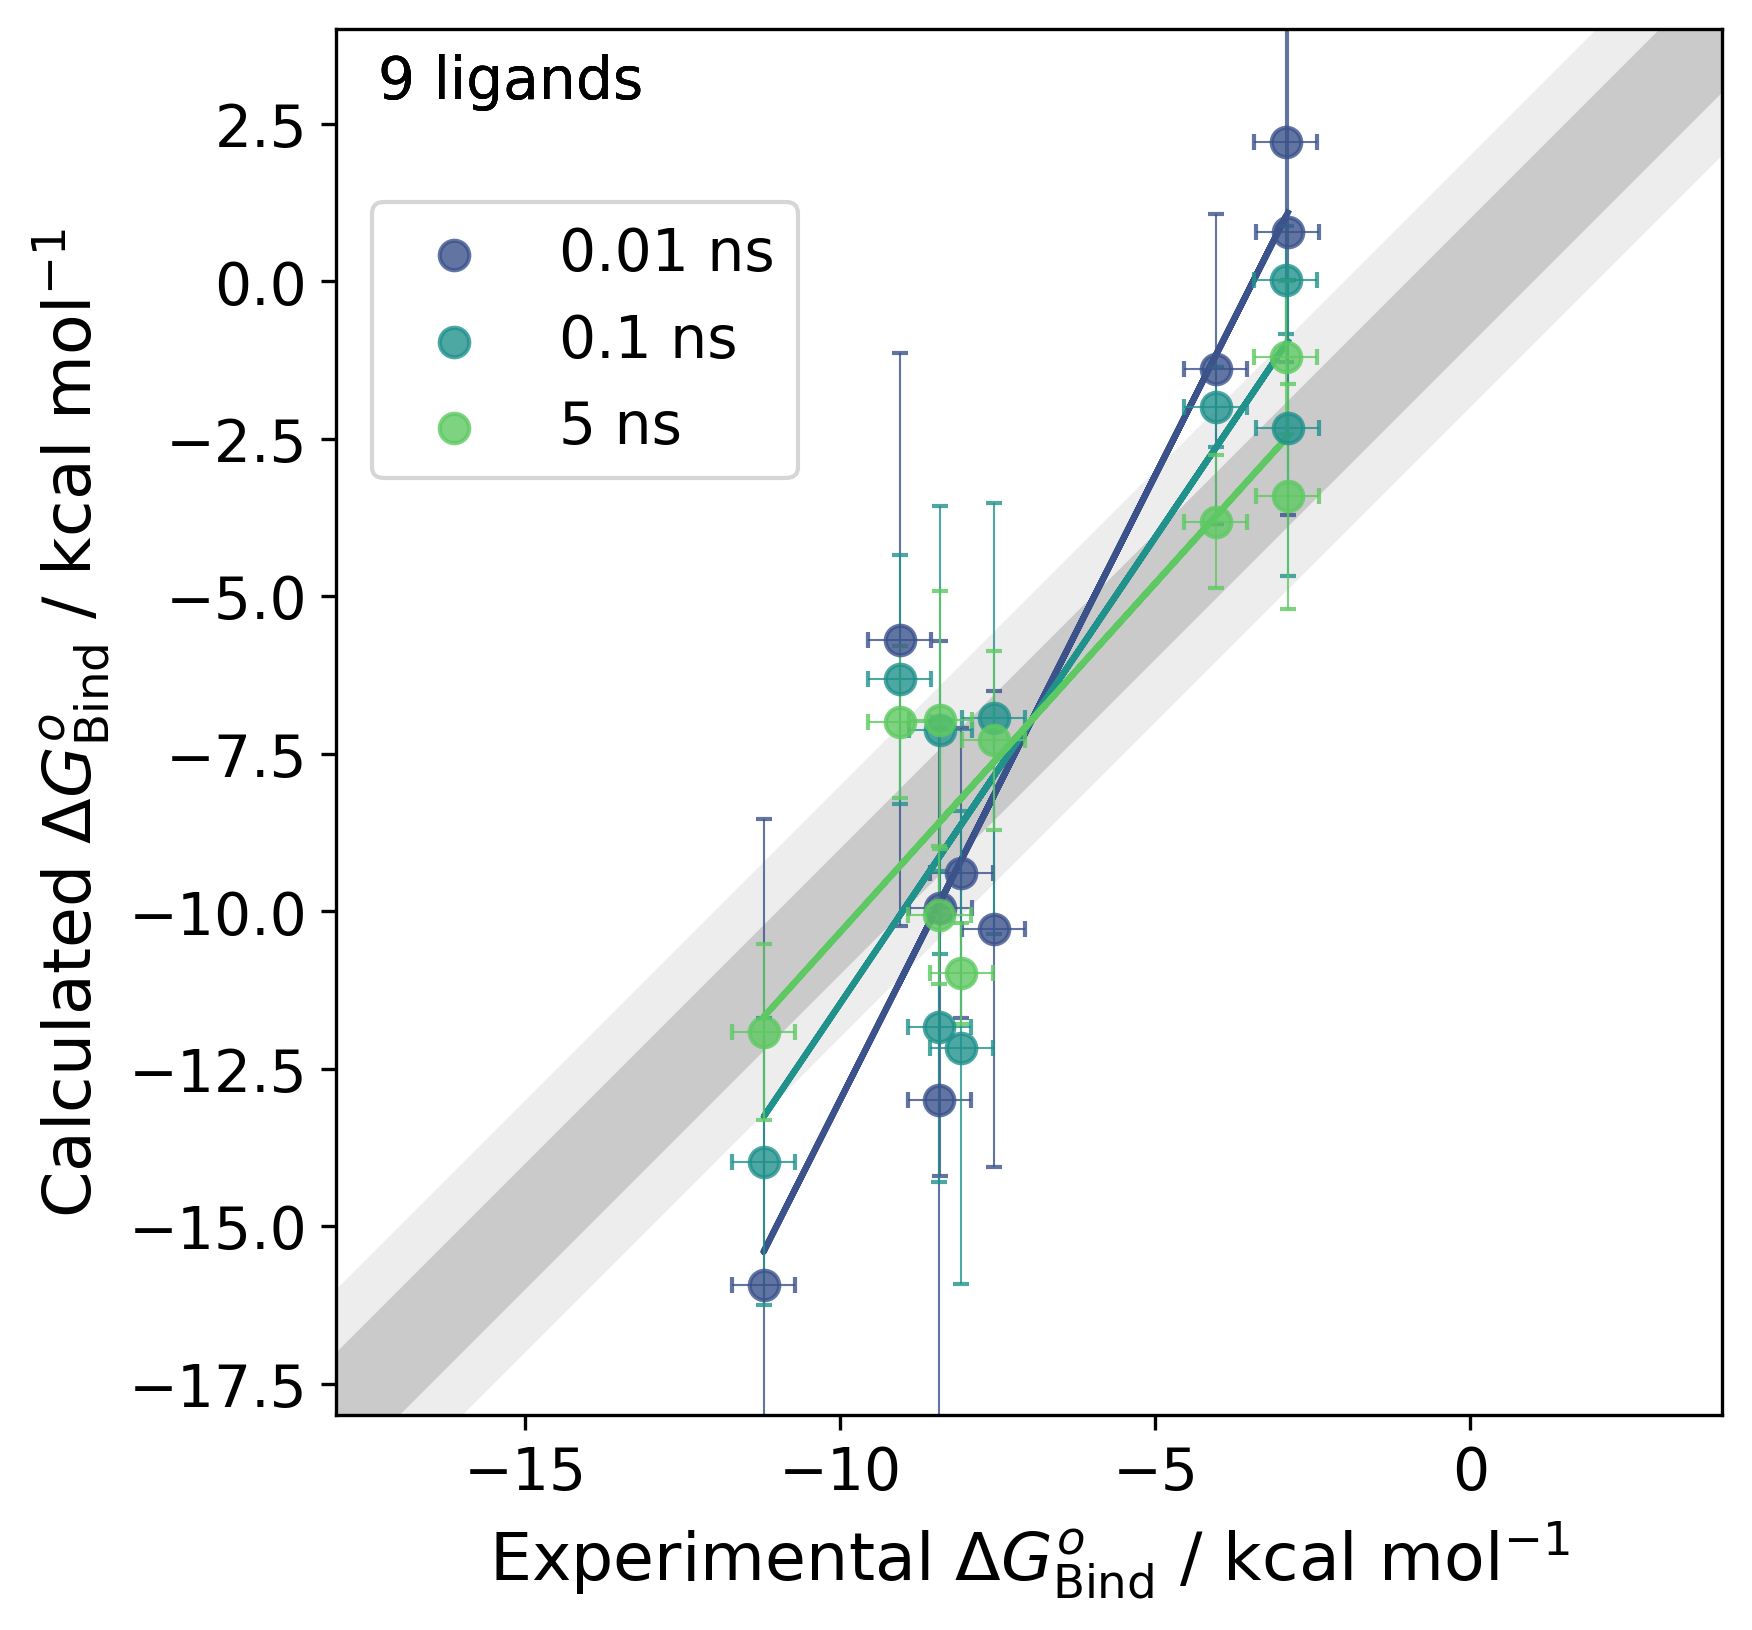

In [113]:
# Plot with offsetting
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
add_centre_lines(ax)
for i, name in enumerate(dfs):
    offset_res =dfs[name].copy()
    shift = offset_res["exp_dg"].mean() - offset_res["calc_dg"].mean()
    offset_res["calc_dg"] += shift
    plot_against_exp_multi(ax=ax, all_results=offset_res, output_dir="output", offset=False, limits=[-18, 4], name=name, color=colors[i])
    # Add line of best fit
    x = offset_res["exp_dg"]
    y = offset_res["calc_dg"]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    ax.plot(x, intercept + slope*x, color=colors[i])

fig.legend(bbox_to_anchor=(0.4,0.8))
fig.savefig("output/all_times_to_exp_offset_lines", dpi=300, bbox_inches="tight")

## How Do the Metrics Change as We Increase Simulation Time?

In [114]:
# Get Dictionaries of all the non-offset metrics
all_stats = {}
for name in dfs:
    all_stats[name] = compute_stats(dfs[name], n_replicates=5)

/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[i], scale=exp_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=calc_dg[i], scale=calc_sem[i]) for i in indices]
/tmp/ipykernel_4004679/2652605412.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [_np.random.normal(loc=exp_dg[

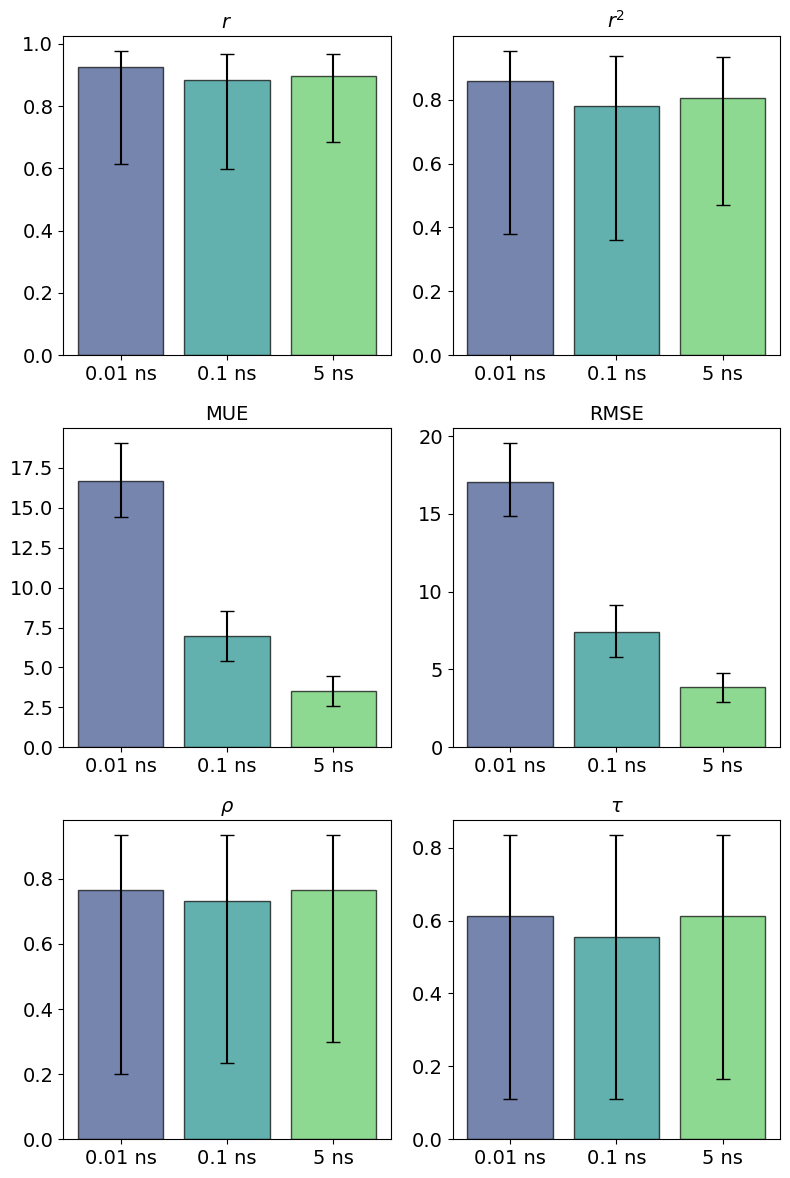

In [130]:
# Metric names to labels
metric_names_to_labels = {"r": "$r$", "r2": "$r^2$", "mue":"MUE", "rmse":"RMSE", "rho":r"$\rho$", "tau": r"$\tau$"}

# Create a subplot for each metric
fig, axs = plt.subplots(3, 2, figsize=(8, 12))
axs = axs.flatten()

for ax, metric_name in zip(axs, all_stats["5 ns"].keys()):
    for simulation_name, stats in all_stats.items():
        value, lower_ci, upper_ci = stats[metric_name]
        ax.bar(simulation_name, value, alpha=0.7, edgecolor="k")
        ax.errorbar(simulation_name, value, yerr=[[value - lower_ci], [upper_ci - value]], label=simulation_name, capsize=5, color="k")
    ax.set_title(metric_names_to_labels[metric_name])
    ax.legend

fig.tight_layout()
fig.savefig("output/metrics_vs_time", bbox_inches="tight", dpi=300)

## How Does the Precision Change as We Increase Simulation Time?

And does it go down with sqrt t?

In [133]:
d = dfs["5 ns"]

In [138]:
d.loc["lig_2_5000ps"]

calc_base_dir    /home/finlayclark/Documents/research/fast_abfe...
exp_dg                                                       -9.06
exp_er                                                         0.5
calc_cor                                                         0
calc_dg_1                                               -11.014637
calc_er_1                                                 0.141236
calc_dg_2                                                -11.67285
calc_er_2                                                 0.144615
calc_dg_3                                               -10.194584
calc_er_3                                                 0.140045
calc_dg_4                                               -10.637021
calc_er_4                                                 0.139709
calc_dg_5                                                 -9.07821
calc_er_5                                                 0.142007
calc_dg                                                  -10.5

In [144]:
4/0.008

500.0

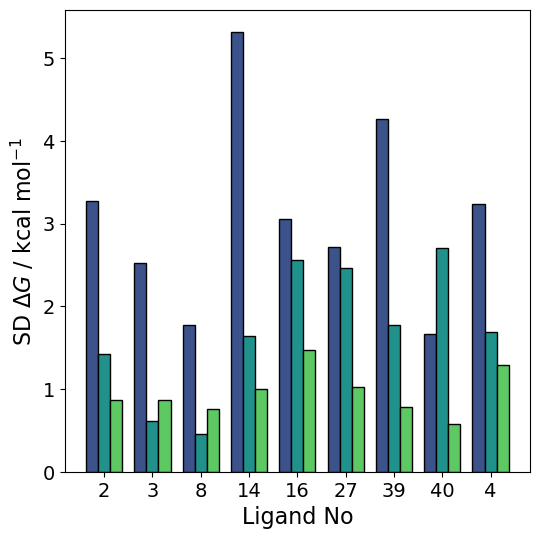

In [163]:
# Plot the per-ligand variance in the free energy estimates
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
variances_all = {}

offsets = [-0.25, 0, 0.25]
for i, (name, df) in enumerate(dfs.items()):
    ligs = list(df.index)
    lig_nos = [l.split("_")[1] for l in ligs]
    variances = []
    for lig in ligs:
        res = [df.loc[lig][f"calc_dg_{i}"] for i in range(1, 6)]
        variances.append(np.std(res))
    variances_all[name] = np.array(variances)**2


    # Add bars
    centers = list(range(len(lig_nos)))
    # ax.bar(lig_nos, variances, alpha=0.5, edgecolor="k")
    ax.bar([x + offsets[i] for x in centers], variances, alpha=1, edgecolor="k", width=0.25)

# Set x-ticks and x-tick labels
ax.set_xticks(centers)
ax.set_xticklabels(lig_nos)

ax.set_xlabel("Ligand No")
ax.set_ylabel("SD $\Delta G$ / kcal mol$^{-1}$")

fig.savefig("output/precision", bbox_inches="tight", dpi=300)


In [165]:
# Figure out the average reduction in variance between 0.01 ns and 0.1 ns, and 0.1 ns and 5 ns

# 0.01 to 0.1 ns
expected = 10
actual = np.mean(variances_all["0.01 ns"] / variances_all["0.1 ns"])

print(expected, actual)

10 6.677297421831235


In [166]:
# 0.1 to 5 ns
expected = 4 / 0.08
actual = np.mean(variances_all["0.1 ns"] / variances_all["5 ns"])

print(expected, actual)

50.0 4.838437578640875


## Find Some Metric to Describe the per-ligand change in ranking performance - distance to line of best fit?

## Original Results - Missing Water

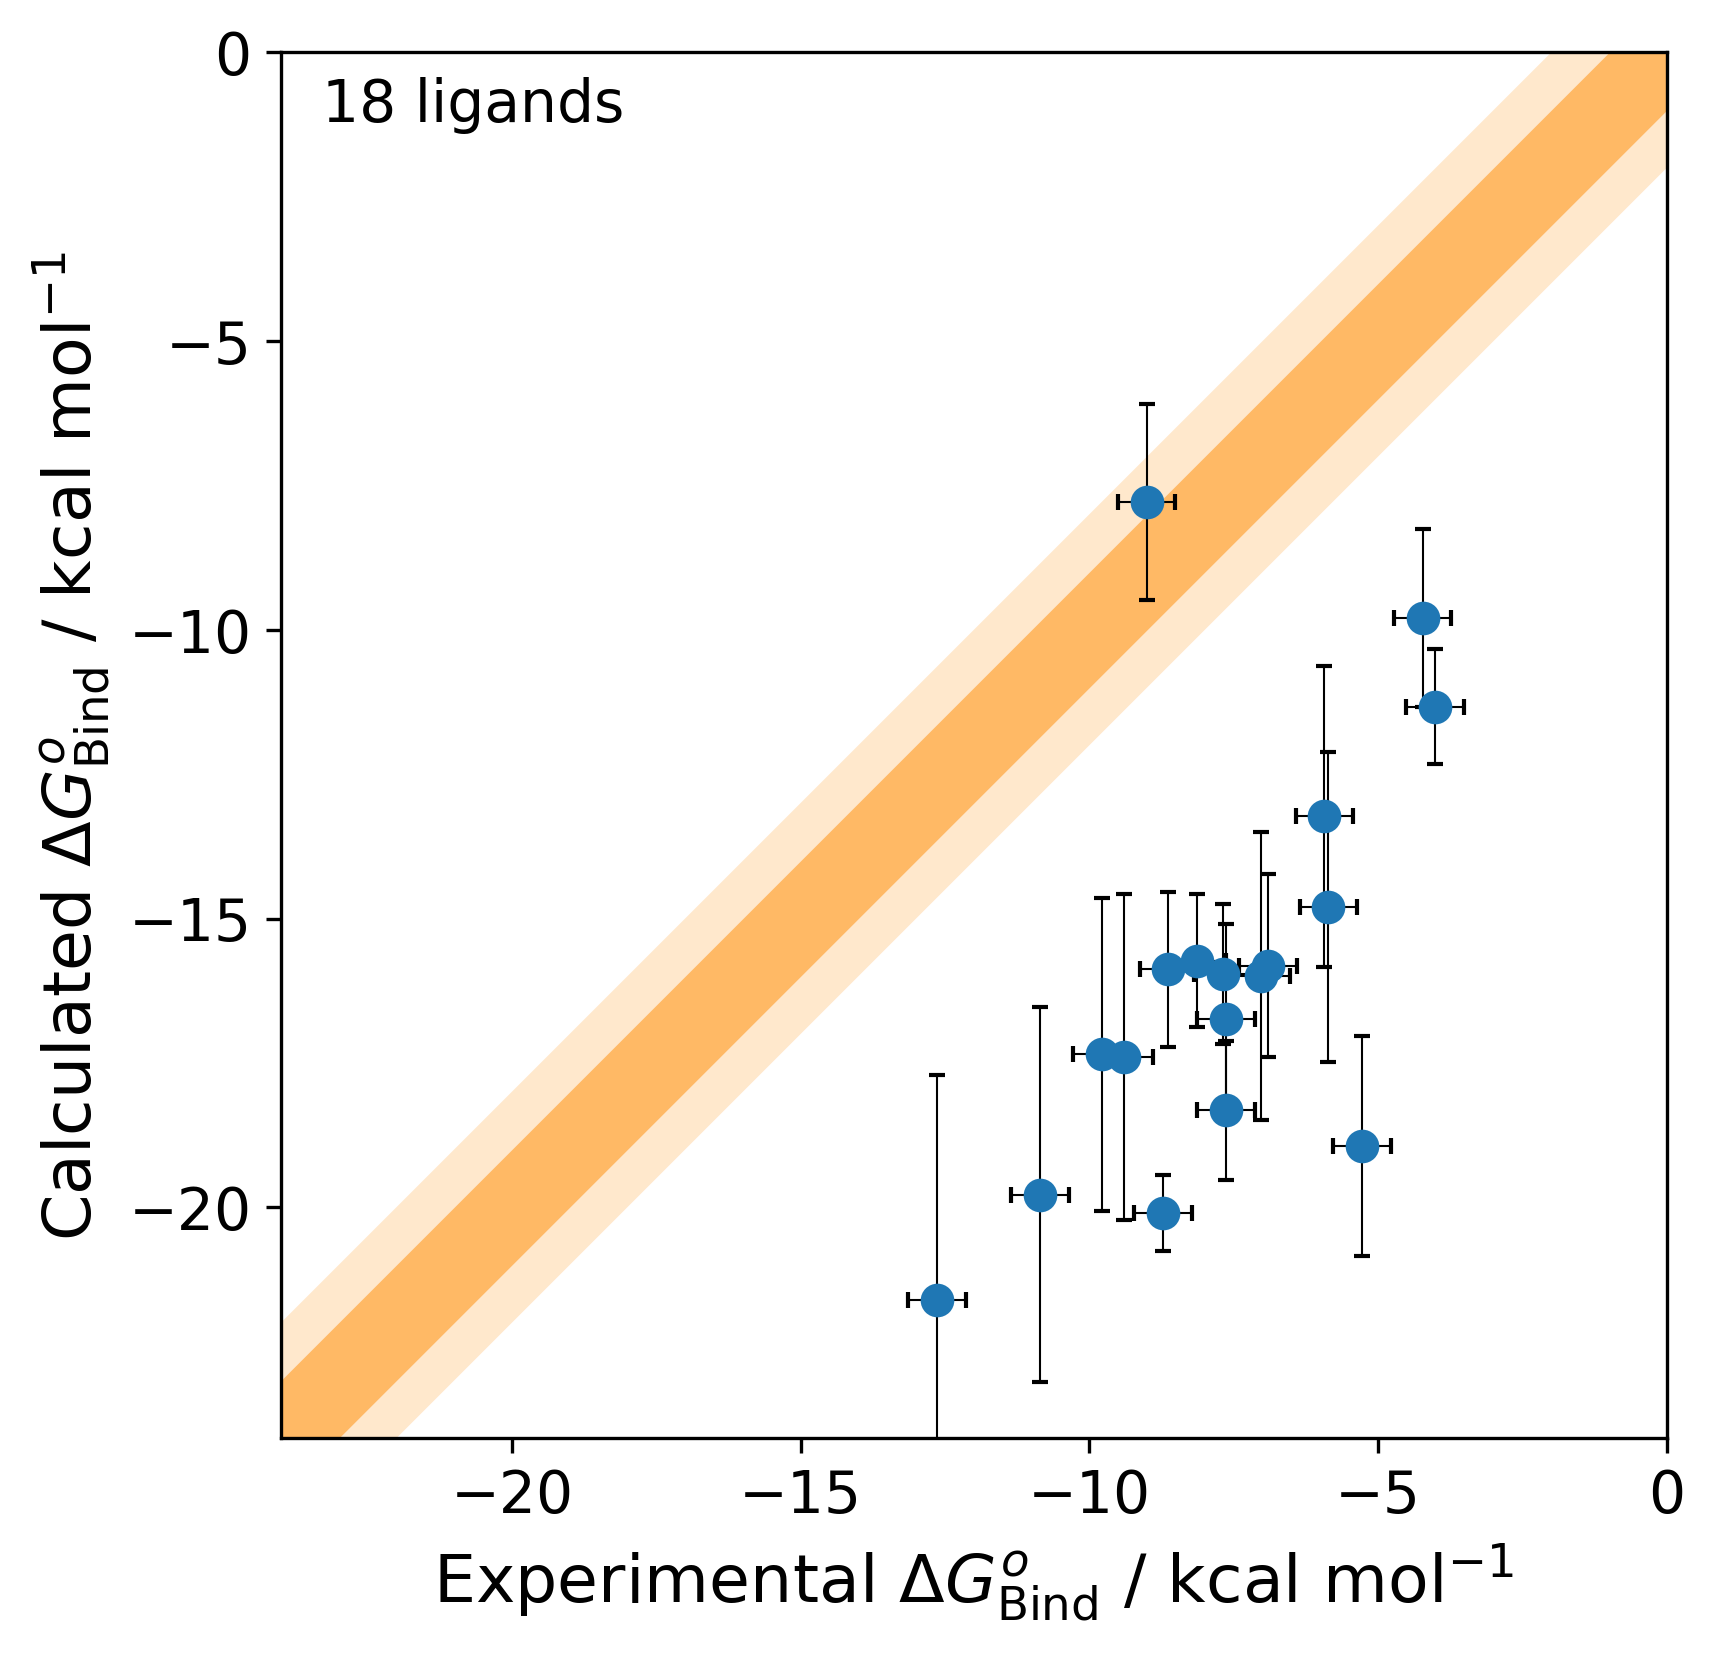

In [17]:
dgs_orig = all_dgs.drop(15).reset_index(drop=True)
stats = compute_stats(dgs_orig, n_replicates=5)
fig, ax = plot_against_exp(all_results=dgs_orig, output_dir="output", offset=False)
fig.savefig("output/calc_v_exp_no_water.png", dpi=300, bbox_inches="tight")

In [18]:
stats

{'r': [0.5662427204699536, 0.10846564713168, 0.870361296088734],
 'r2': [0.320630818485214, 0.01556079810791923, 0.7575287873181429],
 'mue': [8.311865946438981, 7.255975940086058, 9.33272287725627],
 'rmse': [8.665944195192171, 7.777725994268817, 9.698421183830026],
 'rho': [0.5410429218688851, 0.0649122807017544, 0.8163054695562436],
 'tau': [0.419674386861138, 0.032679738562091505, 0.6601307189542485]}

## With Water Inserted

In [19]:
all_dgs

,name,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,calc_dg,calc_er
0,lig_15,/home/finlayclark/Documents/research/fast_abfe...,-4.02,0.5,NaN,-10.754320,0.668575,-11.302691,0.660632,-11.122453,0.681423,-12.704290,0.639496,-10.768725,0.658570,-11.330496,0.996997
1,lig_30,/home/finlayclark/Documents/research/fast_abfe...,-10.86,0.5,NaN,-20.836217,0.722866,-18.866330,0.710320,-22.078740,0.714327,-21.500888,0.713523,-15.626810,0.747338,-19.781797,3.252414
2,lig_26,/home/finlayclark/Documents/research/fast_abfe...,-8.73,0.5,NaN,-19.544933,0.741831,-20.885520,0.743379,-20.328429,0.742720,-20.030601,0.746864,-19.701543,0.738435,-20.098206,0.663126
3,lig_28,/home/finlayclark/Documents/research/fast_abfe...,-9.78,0.5,NaN,-19.444677,0.700756,-17.674823,0.692488,-13.658178,0.705363,-17.772344,0.698163,-18.197240,0.691561,-17.349453,2.707491
4,lig_29,/home/finlayclark/Documents/research/fast_abfe...,-9.40,0.5,NaN,-16.763750,0.740250,-20.713640,0.723746,-17.771168,0.745997,-17.392138,0.745652,-14.380436,0.753032,-17.404227,2.820555
5,lig_21,/home/finlayclark/Documents/research/fast_abfe...,-8.13,0.5,NaN,-14.887778,0.703682,-15.809994,0.701181,-16.364417,0.705446,-16.881866,0.701487,-14.730090,0.704303,-15.734829,1.152262
6,lig_19,/home/finlayclark/Documents/research/fast_abfe...,-5.86,0.5,NaN,-14.958393,0.710053,-18.279767,0.705322,-12.789243,0.723102,-13.235346,0.738535,-14.720064,0.717058,-14.796563,2.679772
7,lig_16,/home/finlayclark/Documents/research/fast_abfe...,-5.93,0.5,NaN,-12.882246,0.689767,-13.071739,0.669797,-16.395685,0.660752,-10.486834,0.681699,-13.320447,0.677155,-13.231390,2.611975
8,lig_25,/home/finlayclark/Documents/research/fast_abfe...,-7.64,0.5,NaN,-18.315349,0.817948,-18.937384,0.808479,-19.118783,0.813090,-18.560251,0.818504,-16.682896,0.822948,-18.322932,1.203362
9,lig_27,/home/finlayclark/Documents/research/fast_abfe...,-8.63,0.5,NaN,-16.412532,0.680564,-16.649198,0.680278,-15.014074,0.676505,-16.887530,0.674863,-14.439622,0.669608,-15.880592,1.348062


In [24]:
stats = compute_stats(dgs_outlier_removed.drop(10).reset_index(drop=True), n_replicates=5)

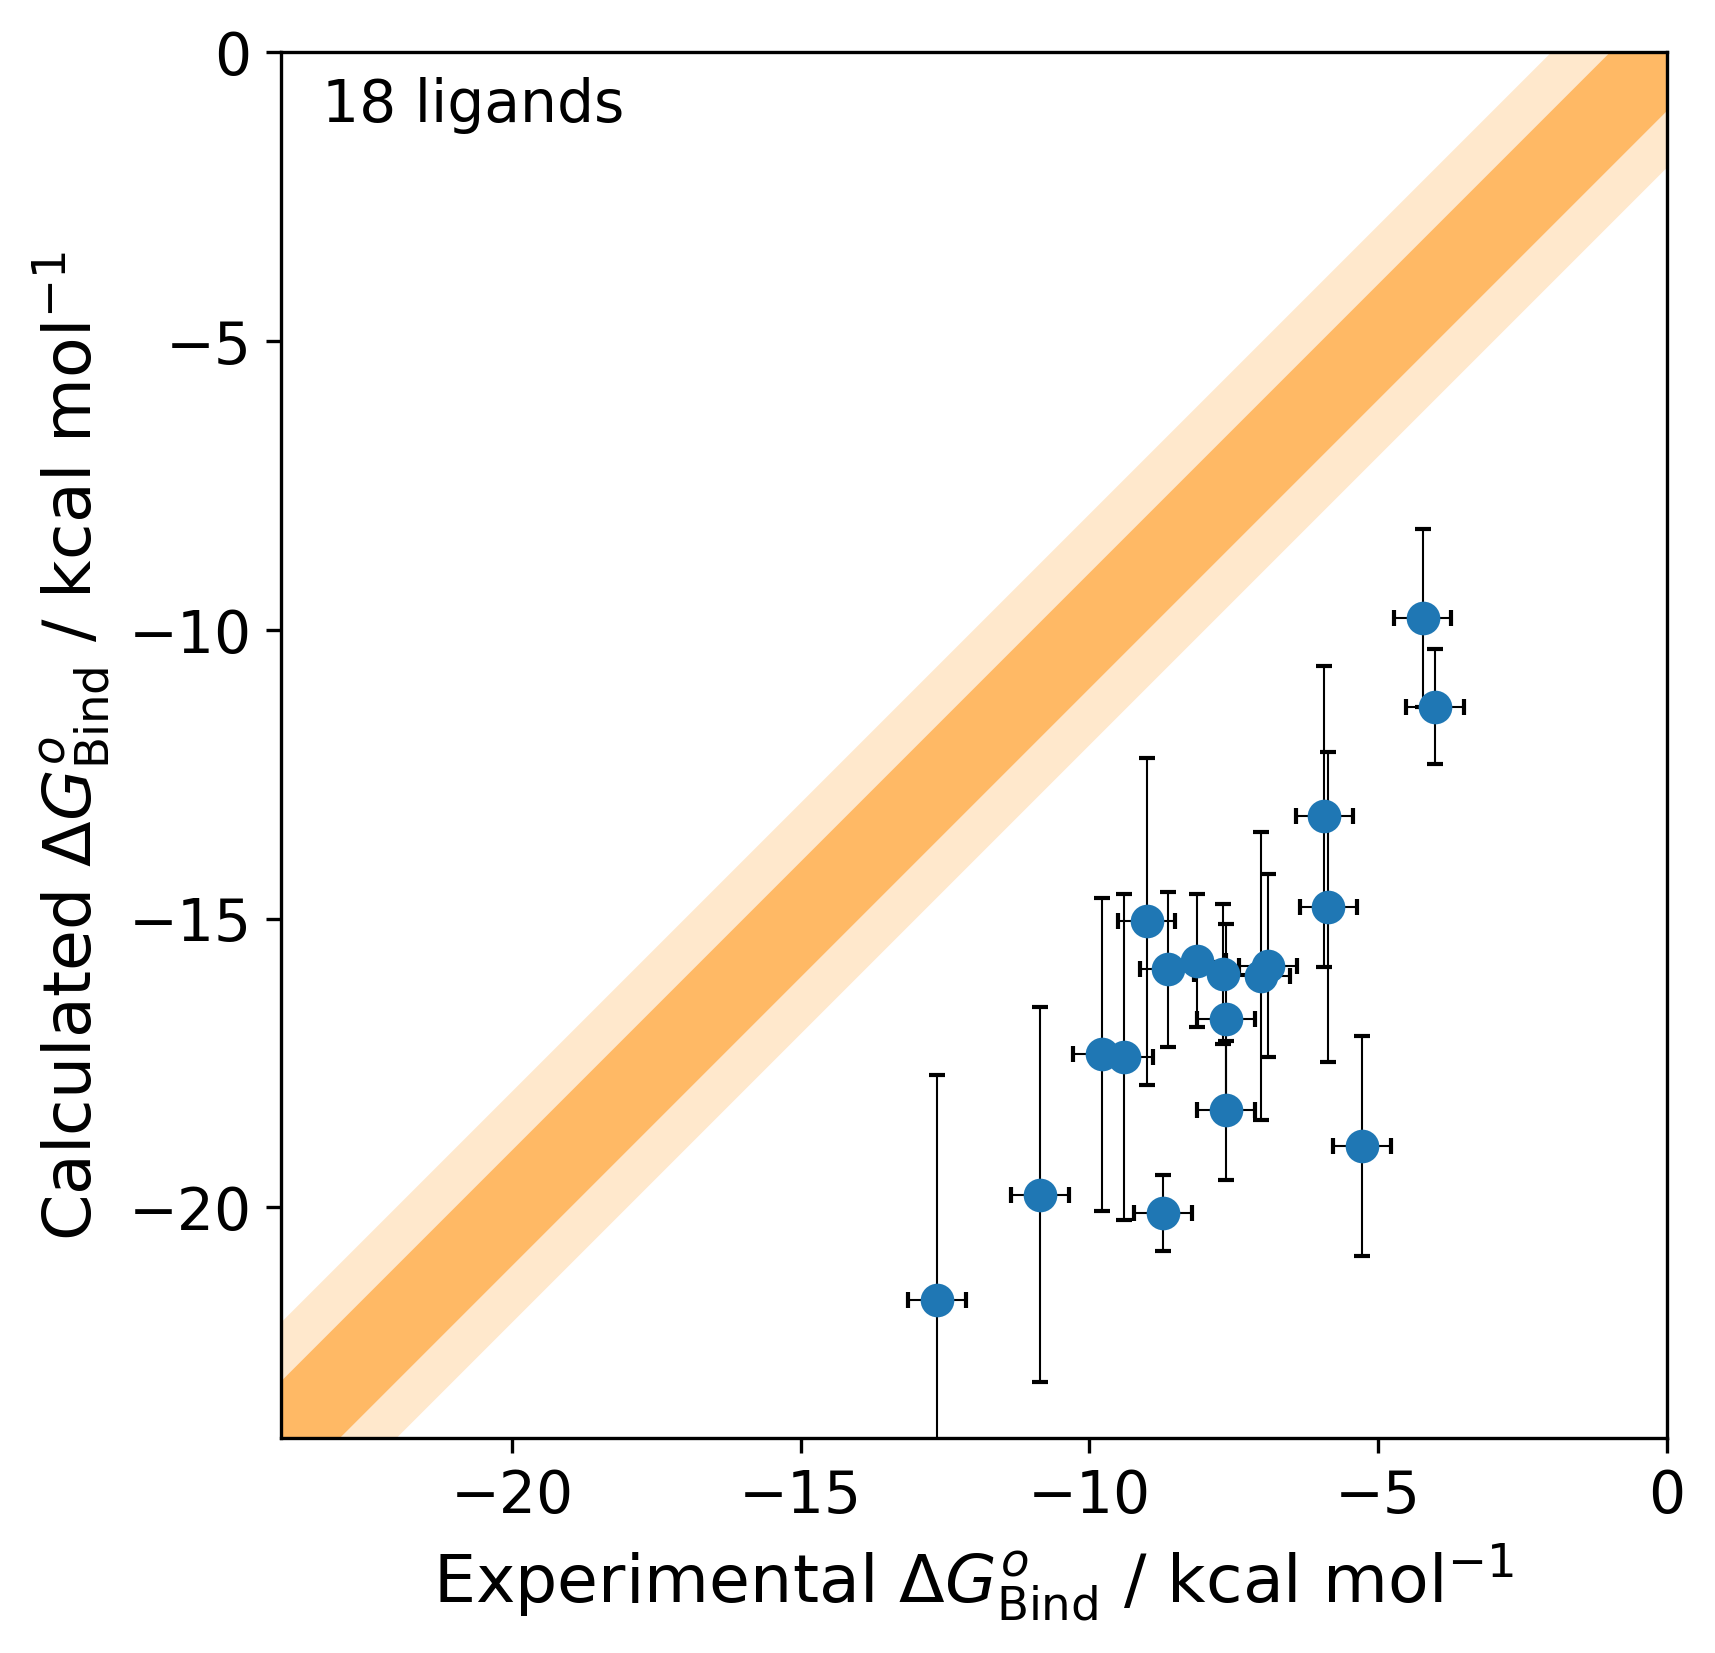

In [5]:
dgs_outlier_removed = all_dgs.drop(14).reset_index(drop=True)
stats = compute_stats(dgs_outlier_removed, n_replicates=5)
fig, ax = plot_against_exp(all_results=dgs_outlier_removed, output_dir="output", offset=False)
fig.savefig("output/calc_v_exp_no_water_no_outlier.png", dpi=300, bbox_inches="tight")

In [21]:
stats

{'r': [0.7655358883368444, 0.3353407898808631, 0.8947230567933313],
 'r2': [0.5860451963316815, 0.11245596967998538, 0.8005296314282371],
 'mue': [8.579415057401496, 7.744654207774277, 9.471627874734919],
 'rmse': [8.777407638589983, 7.940334177924272, 9.760467042647077],
 'rho': [0.6319050919537361, 0.1867905056759546, 0.8390092879256965],
 'tau': [0.4721336852187803, 0.12352941176470593, 0.673202614379085]}

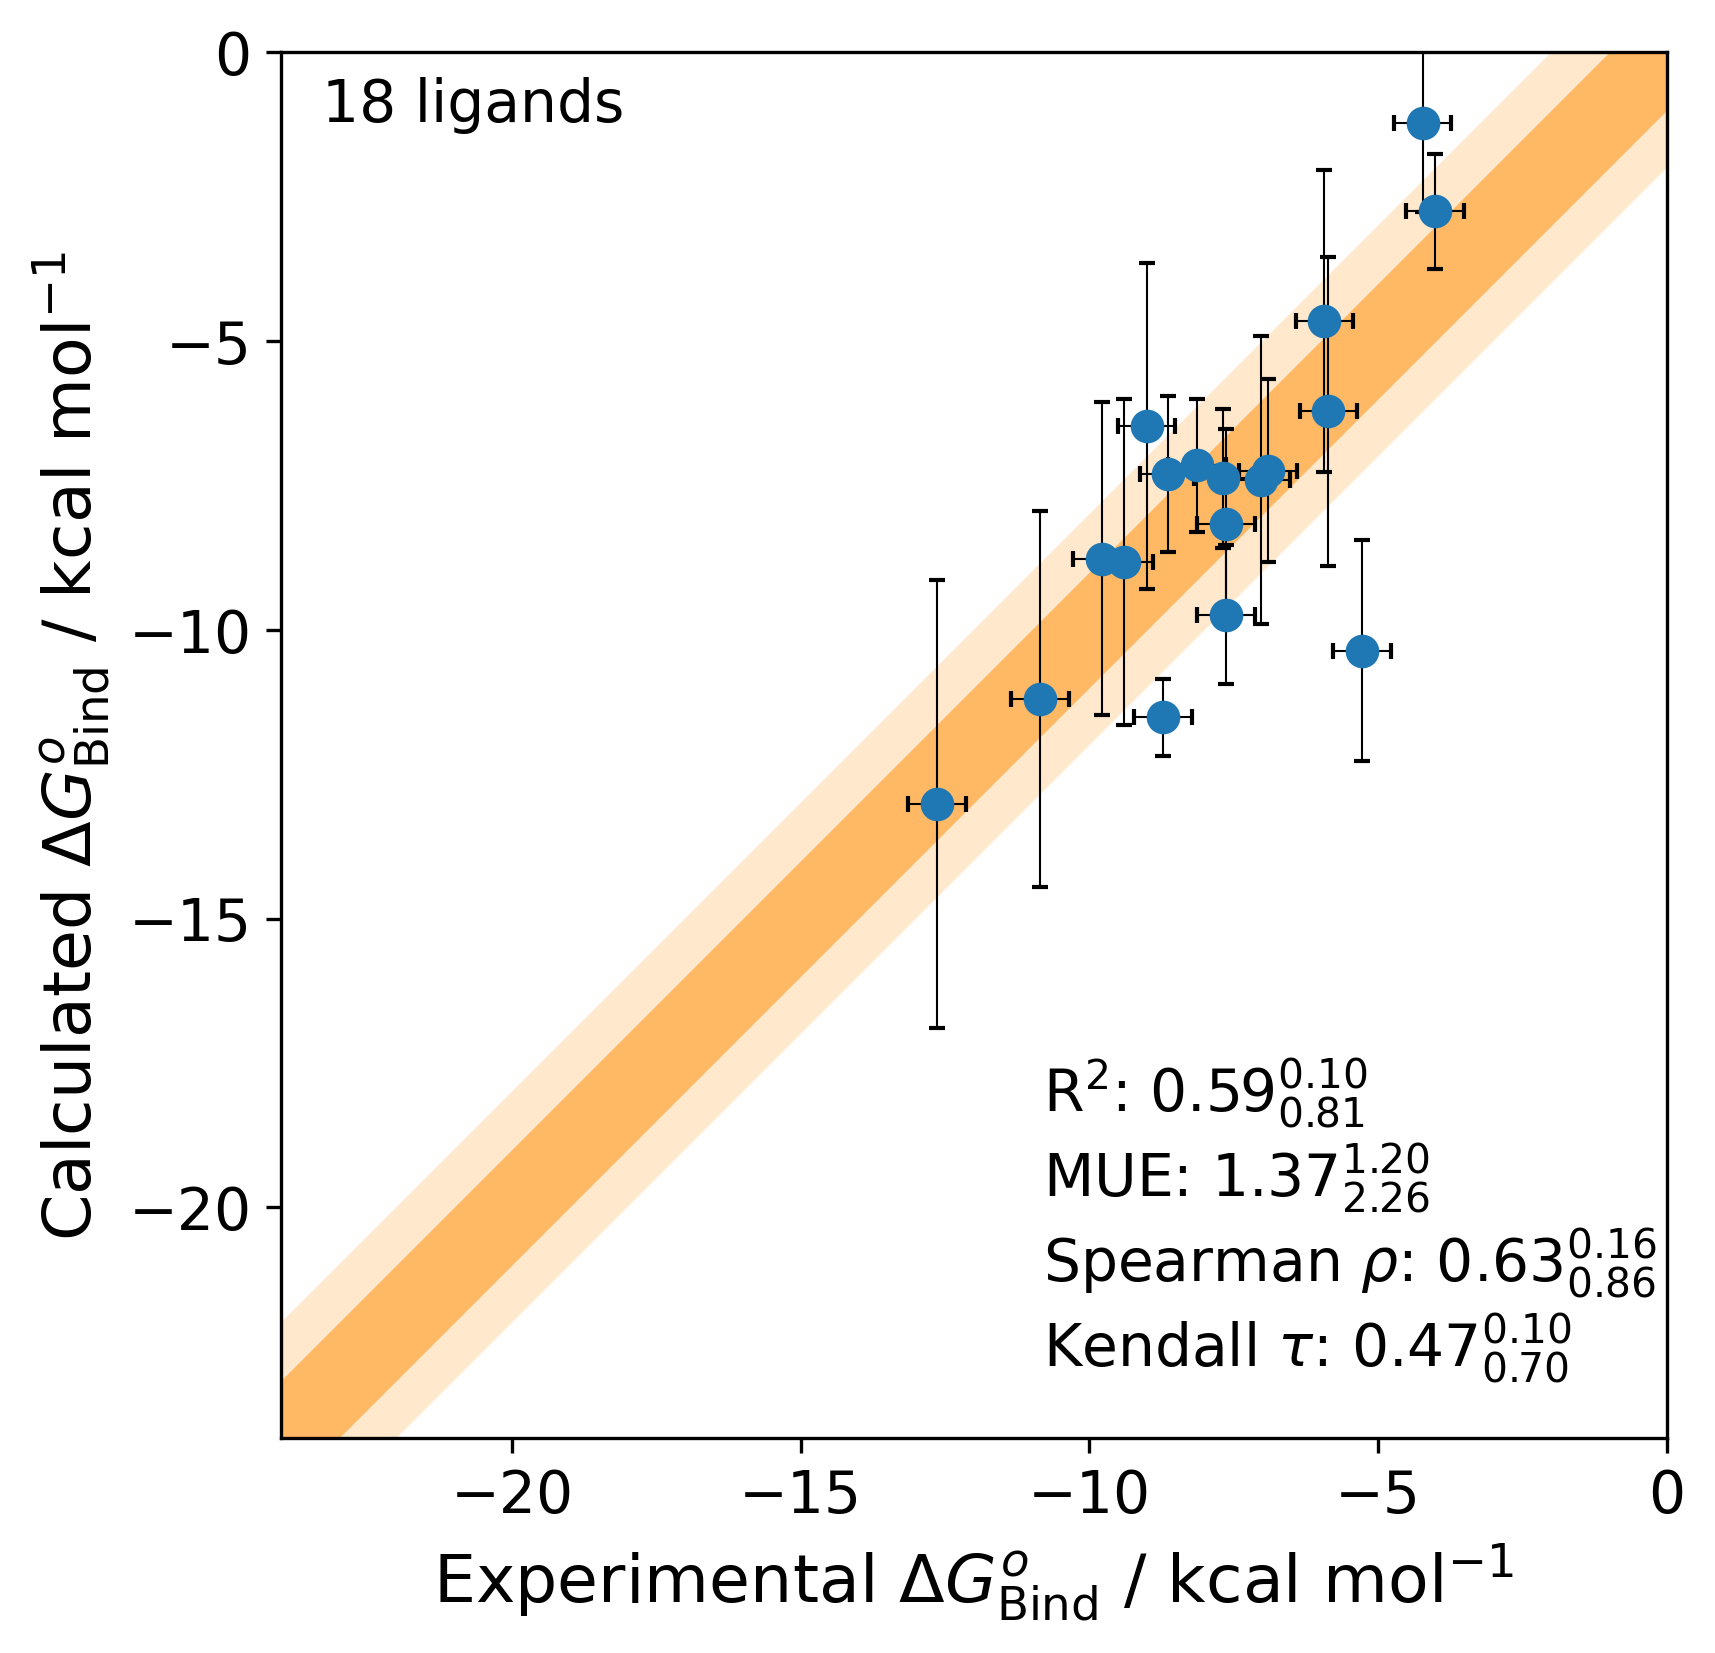

In [22]:
dgs_outlier_removed_offset =dgs_outlier_removed.copy()
# Offset the calc_dg results
shift = dgs_outlier_removed_offset["exp_dg"].mean() - dgs_outlier_removed_offset["calc_dg"].mean()
dgs_outlier_removed_offset["calc_dg"] += shift

stats = compute_stats(dgs_outlier_removed_offset, n_replicates=5)
fig, ax = plot_against_exp(all_results=dgs_outlier_removed_offset, output_dir="output", offset=False, stats=stats)
fig.savefig("output/calc_v_exp_no_water_no_outlier_offset.png", dpi=300, bbox_inches="tight")

In [23]:
stats

{'r': [0.7655358883368444, 0.3208485850886122, 0.9013052417662817],
 'r2': [0.5860451963316818, 0.10443042818509822, 0.8123511691729529],
 'mue': [1.366257773610979, 1.198080995194959, 2.2645040428239813],
 'rmse': [1.853785890228502, 1.5108260668253644, 2.8177788057707733],
 'rho': [0.6319050919537361, 0.16408668730650156, 0.8555211558307534],
 'tau': [0.4721336852187803, 0.09803921568627452, 0.6993464052287582]}

# How Does Probability of Predicting Correct Sign of dG Change Vary with Difference in Experimental Free Energies?

In [6]:
# Get average probability of correct ranking as a function of the experimental difference between the dg of the two ligands
# Bin into 1 kcal/mol bins
from dataclasses import dataclass

# First, create single result and pair objects
@dataclass
class Result:
    exp_dg: float
    calc_dgs: _List[float]

    @property
    def calc_dg(self):
        return _np.mean(self.calc_dgs)

    def get_calc_dg_random(self, n_repeats: int):
        """Useful for bootstrapping, where we want to resample the calculated dgs."""
        return _np.mean(_np.random.choice(self.calc_dgs, n_repeats, replace=True))

@dataclass
class Pair:
    lig1: Result
    lig2: Result

    @property
    def exp_diff(self):
        return self.lig1.exp_dg - self.lig2.exp_dg
    
    @property
    def abs_exp_diff(self):
        return abs(self.exp_diff)

    @property
    def calc_diff(self):
        return self.lig1.calc_dg - self.lig2.calc_dg

    @property
    def abs_calc_diff(self):
        return abs(self.calc_diff)
    
    @property
    def correct_ranking(self):
        return self.exp_diff * self.calc_diff > 0

    def get_calc_diff_random(self, n_repeats: int):
        """Useful for bootstrapping, where we want to resample the calculated dgs."""
        return self.lig1.get_calc_dg_random(n_repeats) - self.lig2.get_calc_dg_random(n_repeats)

    def get_correct_ranking_random(self, n_repeats: int):
        """Useful for bootstrapping, where we want to resample the calculated dgs."""
        return self.exp_diff * self.get_calc_diff_random(n_repeats) > 0


In [7]:
# Sort by experimental dg
all_dgs = dgs_outlier_removed
all_dgs.sort_values("exp_dg")

,name,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,calc_dg,calc_er
15,lig_31,/home/finlayclark/Documents/research/fast_abfe...,-12.64,0.5,NaN,-26.088651,0.757563,-17.575362,0.772331,-20.421378,0.756936,-21.210480,0.775558,-22.705996,0.758939,-21.600373,3.882549
1,lig_30,/home/finlayclark/Documents/research/fast_abfe...,-10.86,0.5,NaN,-20.836217,0.722866,-18.866330,0.710320,-22.078740,0.714327,-21.500888,0.713523,-15.626810,0.747338,-19.781797,3.252414
3,lig_28,/home/finlayclark/Documents/research/fast_abfe...,-9.78,0.5,NaN,-19.444677,0.700756,-17.674823,0.692488,-13.658178,0.705363,-17.772344,0.698163,-18.197240,0.691561,-17.349453,2.707491
4,lig_29,/home/finlayclark/Documents/research/fast_abfe...,-9.40,0.5,NaN,-16.763750,0.740250,-20.713640,0.723746,-17.771168,0.745997,-17.392138,0.745652,-14.380436,0.753032,-17.404227,2.820555
14,lig_24_water,/home/finlayclark/Documents/research/fast_abfe...,-9.01,0.5,NaN,-14.369570,0.728736,-18.076859,0.725980,-12.139479,0.749336,-16.441559,0.749960,-14.229899,0.738891,-15.051473,2.824955
2,lig_26,/home/finlayclark/Documents/research/fast_abfe...,-8.73,0.5,NaN,-19.544933,0.741831,-20.885520,0.743379,-20.328429,0.742720,-20.030601,0.746864,-19.701543,0.738435,-20.098206,0.663126
9,lig_27,/home/finlayclark/Documents/research/fast_abfe...,-8.63,0.5,NaN,-16.412532,0.680564,-16.649198,0.680278,-15.014074,0.676505,-16.887530,0.674863,-14.439622,0.669608,-15.880592,1.348062
5,lig_21,/home/finlayclark/Documents/research/fast_abfe...,-8.13,0.5,NaN,-14.887778,0.703682,-15.809994,0.701181,-16.364417,0.705446,-16.881866,0.701487,-14.730090,0.704303,-15.734829,1.152262
17,lig_22,/home/finlayclark/Documents/research/fast_abfe...,-7.69,0.5,NaN,-15.159285,0.724878,-16.061290,0.716371,-14.783003,0.729311,-16.866585,0.712703,-16.922314,0.737541,-15.958495,1.207779
8,lig_25,/home/finlayclark/Documents/research/fast_abfe...,-7.64,0.5,NaN,-18.315349,0.817948,-18.937384,0.808479,-19.118783,0.813090,-18.560251,0.818504,-16.682896,0.822948,-18.322932,1.203362


In [8]:
# Now, create a list of all N(N-1)/2 pairs
pairs = []
for i in range(len(all_dgs)):
    for j in range(i + 1, len(all_dgs)):
        pair = Pair(
            lig1=Result(all_dgs["exp_dg"][i], [all_dgs[f"calc_dg_{k}"][i] for k in range(1, 6)]),
            lig2=Result(all_dgs["exp_dg"][j], [all_dgs[f"calc_dg_{k}"][j] for k in range(1, 6)])
        )
        pairs.append(pair)

In [9]:
# Now, get the average probability of correct ranking
len([pair for pair in pairs if pair.correct_ranking]) / len(pairs)

0.7320261437908496

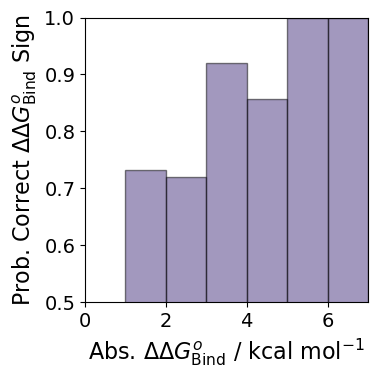

In [30]:
# Now, get the average probability of correct ranking as a function of the experimental difference between the dg of the two ligands
# Bin into 1 kcal/mol bins
bins = _np.arange(0, 8, 1)
prob_correct = []
pairs_binned = []
for i in range(len(bins) - 1):
    bin_pairs = [pair for pair in pairs if bins[i] <= pair.abs_exp_diff < bins[i + 1]]
    if len(bin_pairs) == 0:
        prob_correct.append(0)
        continue
    prob_correct.append(len([pair for pair in bin_pairs if pair.correct_ranking]) / len(bin_pairs))
    pairs_binned.append(bin_pairs)

# Set nice colour scheme
sns.set_palette("viridis")

# Plot bars for each binned region
fig, ax = _plt.subplots(1, 1, figsize=(4, 4))
# Set grid, but make sure it's behind the bars
ax.bar([x+0.5 for x in bins[:-1]], prob_correct, width=1, alpha=0.5, edgecolor="black")
ax.set_xlabel("Abs. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Prob. Correct $\Delta \Delta G^o_{\mathrm{Bind}}$ Sign")
ax.set_ylim([0.5, 1])
ax.set_xlim([0, 7])
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking.png", dpi=300)


In [11]:
# Function to create pairs
def get_pairs(all_dgs: _pd.DataFrame, random_results:bool = False) -> _List[Pair]:
    """
    Create pairs of ligands from the passed DataFrame.

    Parameters
    ----------
    all_dgs : pd.DataFrame
        A DataFrame containing the experimental and calculated free energy changes.

    random_results: bool
        Whether to randomly resample the calculated results from the dataframe. Useful for bootstrapping.

    Returns
    -------
    List[Pair]
        A list of pairs of ligands.
    """
    # Sort by experimental dg
    all_dgs.sort_values("exp_dg")

    # Decide which calc_dg columns to use
    n_results = len(all_dgs)
    if random_results:
        row_indices = _np.random.choice(_np.arange(n_results), n_results, replace=True)
    else:
        row_indices = _np.arange(n_results)

    # Now, create a list of all N(N-1)/2 pairs
    pairs = []
    for i, row_idx_1 in enumerate(row_indices):
        for j, row_idx_2 in enumerate(row_indices):
            if i >= j:
                continue
            pair = Pair(
                lig1=Result(all_dgs["exp_dg"][row_idx_1], [all_dgs[f"calc_dg_{k}"][row_idx_1] for k in range(1, 6)]),
                lig2=Result(all_dgs["exp_dg"][row_idx_2], [all_dgs[f"calc_dg_{k}"][row_idx_2] for k in range(1, 6)])
            )
            pairs.append(pair)

    return pairs
    

# Function to create bootstrapped pairs
def get_bootstrapped_pairs(all_dgs: _pd.DataFrame, n_bootstrap: int = 1000) -> _List[_List[Pair]]:
    """
    Create bootstrapped pairs of ligands from the passed DataFrame.

    Parameters
    ----------
    all_dgs : pd.DataFrame
        A DataFrame containing the experimental and calculated free energy changes.
    n_bootstrap : int
        The number of bootstrapped samples to create.

    Returns
    -------
    List[List[Pair]]
        A list of lists of pairs of ligands.
    """
    bootstrapped_pairs = []
    for i in range(n_bootstrap):
        pairs = get_pairs(all_dgs, random_results=True)
        bootstrapped_pairs.append(_np.random.choice(pairs, len(pairs), replace=True))
    return bootstrapped_pairs

# Function to calculate probability of correct ranking
def calc_prob_correct(pairs: _List[Pair], random: bool = False, n_repeats: int = 5 ) -> float:
    """
    Calculate the probability of correct ranking for a list of pairs of ligands.

    Parameters
    ----------
    pairs : List[Pair]
        A list of pairs of ligands.
    random: bool
        Whether to randomly resample the calculated results from the dataframe. Useful for bootstrapping.
    n_repeats: int
        The number of repeats to use when resampling the calculated dgs for bootstrapping.

    Returns
    -------
    float
        The probability of correct ranking.
    """
    if random:
        return len([pair for pair in pairs if pair.get_correct_ranking_random(n_repeats)]) / len(pairs)
    return len([pair for pair in pairs if pair.correct_ranking]) / len(pairs)

# Function to calculate probability of correct ranking as a function of the experimental difference between the dg of the two ligands,
# given sets of bootstrapped pairs. This should also provide bootstrapped error bars.
def calc_prob_correct_binned(pairs_lists: _List[_List[Pair]], bins: _np.ndarray, resample_repeats: bool= True, n_repeats: int = 5) -> _Tuple[_np.ndarray, _np.ndarray, _np.ndarray]:
    """
    Calculate the probability of correct ranking for a list of pairs, binned by the experimental difference between the dg of the two ligands.

    Parameters
    ----------
    pairs_lists : List[List[Pair]]
        A list of lists of pairs of ligands.
    bins : np.ndarray
        The bins to use for binning the experimental difference.
    resample_repeats : int, optional, default = 100
        The number of repeats to use when resampling the calculated dgs for bootstrapping.
    n_repeats: int
        The number of repeat runs to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The probability of correct ranking for each bin, and the boostrapped 95 % CI upper and lower bounds.
    """
    bin_results = {b : [] for b in bins}
    # Use tqdm
    for pair_list in tqdm.tqdm(pairs_lists):
        for i in range(len(bins) - 1):
            bin_pairs = [pair for pair in pair_list if bins[i] <= pair.abs_exp_diff < bins[i + 1]]
            if len(bin_pairs) == 0:
                continue
            bin_results[bins[i]].append(calc_prob_correct(bin_pairs, random=resample_repeats, n_repeats=n_repeats))
    
    # Get the statistics
    medians = _np.array([_np.median(bin_results[b]) for b in bins[:-1]])
    upper_errs = _np.array([_np.percentile(bin_results[b], 95) for b in bins[:-1]])
    lower_errs = _np.array([_np.percentile(bin_results[b], 5) for b in bins[:-1]])

    return medians, upper_errs, lower_errs

# Function to plot the probability of correct ranking as a function of the experimental difference between the dg of the two ligands, with error bars
def plot_prob_correct_binned(means: _np.ndarray, upper_errs: _np.ndarray, lower_errs: _np.ndarray, bins: _np.ndarray):
    """
    Plot the probability of correct ranking for a list of pairs, binned by the experimental difference between the dg of the two ligands.

    Parameters
    ----------
    means : np.ndarray
        The mean probability of correct ranking for each bin.
    upper_errs : np.ndarray
        The upper 95 % CI error bars for the probability of correct ranking for each bin.
    lower_errs : np.ndarray
        The lower 95 % CI error bars for the probability of correct ranking for each bin.
    bins : np.ndarray
        The bins to use for binning the experimental difference.
    """
    fig, ax = _plt.subplots(1, 1, figsize=(4.5, 4.5))
    ax.bar([x+0.5 for x in bins[:-1]], means, width=1, alpha=0.5, edgecolor="black", yerr=[means - lower_errs, upper_errs - means], capsize=2)
    ax.set_xlabel("Abs. $\Delta \Delta G_{\mathrm{Bind, Exp.}}$ / kcal mol$^{-1}$")
    ax.set_ylabel("Prob. Correct $\Delta \Delta G_{\mathrm{Bind, Calc.}}$ Sign")
    ax.set_ylim([0.4, 1])
    ax.set_xlim([0, 7])
    fig.tight_layout()
    return fig, ax

100%|██████████| 1000/1000 [00:05<00:00, 183.20it/s]


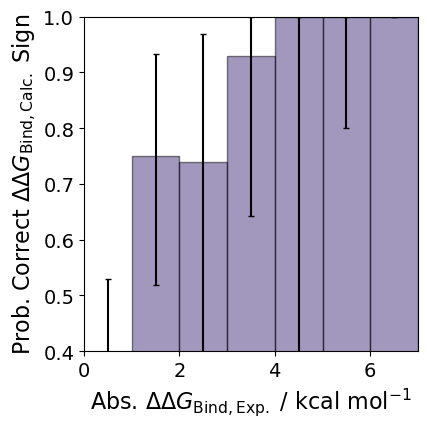

In [32]:
# Let's get the results for all 5 replicates
pairs_lists = get_bootstrapped_pairs(all_dgs, n_bootstrap=1000)
means_5, upper_errs_5, lower_errs_5 = calc_prob_correct_binned(pairs_lists, bins, resample_repeats=100)
# Plot
bins = _np.arange(0, 8, 1)
fig, ax = plot_prob_correct_binned(means_5, upper_errs_5, lower_errs_5, bins)
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking_binned_boostrapped.png", dpi=300, bbox_inches="tight")

100%|██████████| 1000/1000 [00:05<00:00, 179.61it/s]


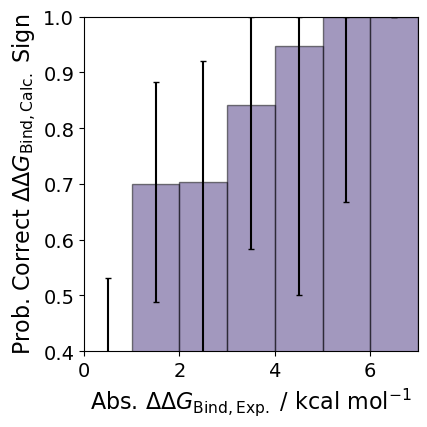

In [33]:
pairs_lists = get_bootstrapped_pairs(all_dgs, n_bootstrap=1000)
means_1, upper_errs_1, lower_errs_1 = calc_prob_correct_binned(pairs_lists, bins, resample_repeats=100, n_repeats=1)
# Plot
bins = _np.arange(0, 8, 1)
fig, ax = plot_prob_correct_binned(means_1, upper_errs_1, lower_errs_1, bins)
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking_binned_boostrapped_1_repeat.png", dpi=300, bbox_inches="tight")

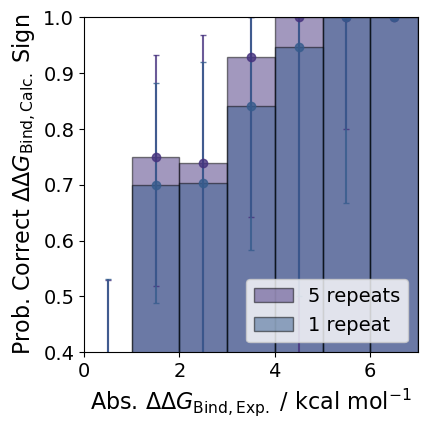

In [34]:
# Plot the 5 repeats and two repeats on the same plot
fig, ax = _plt.subplots(1, 1, figsize=(4.5, 4.5))
# Change the style of the error bars
ax.errorbar([x+0.5 for x in bins[:-1]], means_5, yerr=[means_5 - lower_errs_5, upper_errs_5 - means_5], fmt="o", capsize=2, alpha=0.8)
ax.errorbar([x+0.5 for x in bins[:-1]], means_1, yerr=[means_1 - lower_errs_1, upper_errs_1 - means_1], fmt="o", capsize=2, alpha=0.8)
ax.bar([x+0.5 for x in bins[:-1]], means_5, width=1, alpha=0.5, edgecolor="black", capsize=2, label="5 repeats")
ax.bar([x+0.5 for x in bins[:-1]], means_1, width=1, alpha=0.5, edgecolor="black", capsize=2, label="1 repeat")
ax.set_xlabel("Abs. $\Delta \Delta G_{\mathrm{Bind, Exp.}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Prob. Correct $\Delta \Delta G_{\mathrm{Bind, Calc.}}$ Sign")
ax.set_ylim([0.4, 1.])
ax.set_xlim([0, 7])
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking_binned_boostrapped_comparison.png", dpi=300, bbox_inches="tight")

In [35]:
pairs_lists = get_bootstrapped_pairs(all_dgs, n_bootstrap=1000)
means_3, upper_errs_3, lower_errs_3 = calc_prob_correct_binned(pairs_lists, bins, resample_repeats=100, n_repeats=3)

100%|██████████| 1000/1000 [00:05<00:00, 181.36it/s]


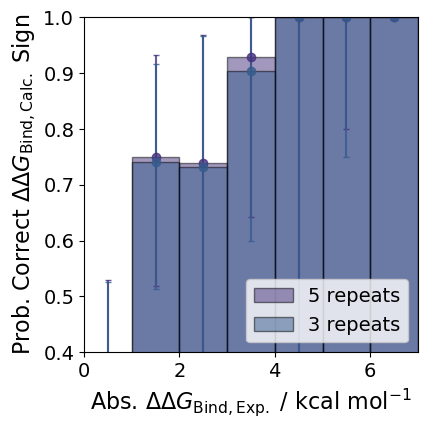

In [36]:
# Plot as above, but compare 5 and 3 repeats
fig, ax = _plt.subplots(1, 1, figsize=(4.5, 4.5))
# Change the style of the error bars
ax.errorbar([x+0.5 for x in bins[:-1]], means_5, yerr=[means_5 - lower_errs_5, upper_errs_5 - means_5], fmt="o", capsize=2, alpha=0.8)
ax.errorbar([x+0.5 for x in bins[:-1]], means_3, yerr=[means_3 - lower_errs_3, upper_errs_3 - means_3], fmt="o", capsize=2, alpha=0.8)
ax.bar([x+0.5 for x in bins[:-1]], means_5, width=1, alpha=0.5, edgecolor="black", capsize=2, label="5 repeats")
ax.bar([x+0.5 for x in bins[:-1]], means_3, width=1, alpha=0.5, edgecolor="black", capsize=2, label="3 repeats")
ax.set_xlabel("Abs. $\Delta \Delta G_{\mathrm{Bind, Exp.}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Prob. Correct $\Delta \Delta G_{\mathrm{Bind, Calc.}}$ Sign")
ax.set_ylim([0.4, 1])
ax.set_xlim([0, 7])
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking_binned_boostrapped_comparison_5_3.png", dpi=300, bbox_inches="tight")

## Repeat as Above but Use the Calculated ddG on the x-Axis

In [37]:
def calc_prob_correct_binned_from_calc(pairs_lists: _List[_List[Pair]], bins: _np.ndarray, resample_repeats: bool= True, n_repeats: int = 5) -> _Tuple[_np.ndarray, _np.ndarray, _np.ndarray]:
    """
    Calculate the probability of correct ranking for a list of pairs, binned by the calculated difference between the dg of the two ligands.

    Parameters
    ----------
    pairs_lists : List[List[Pair]]
        A list of lists of pairs of ligands.
    bins : np.ndarray
        The bins to use for binning the experimental difference.
    resample_repeats : int, optional, default = 100
        The number of repeats to use when resampling the calculated dgs for bootstrapping.
    n_repeats: int
        The number of repeat runs to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The probability of correct ranking for each bin, and the boostrapped 95 % CI upper and lower bounds.
    """
    bin_results = {b : [] for b in bins}
    # Use tqdm
    for pair_list in tqdm.tqdm(pairs_lists):
        for i in range(len(bins) - 1):
            bin_pairs = [pair for pair in pair_list if bins[i] <= pair.abs_calc_diff < bins[i + 1]]
            if len(bin_pairs) == 0:
                continue
            bin_results[bins[i]].append(calc_prob_correct(bin_pairs, random=resample_repeats, n_repeats=n_repeats))

    # Get the statistics
    medians = _np.array([_np.median(bin_results[b]) for b in bins[:-1]])
    upper_errs = _np.array([_np.percentile(bin_results[b], 95) for b in bins[:-1]])
    lower_errs = _np.array([_np.percentile(bin_results[b], 5) for b in bins[:-1]])

    return medians, upper_errs, lower_errs

In [38]:
pairs_lists = get_bootstrapped_pairs(all_dgs, n_bootstrap=1000)
means_5, upper_errs_5, lower_errs_5 = calc_prob_correct_binned_from_calc(pairs_lists, bins, resample_repeats=100, n_repeats=5)
means_1, upper_errs_1, lower_errs_1 = calc_prob_correct_binned_from_calc(pairs_lists, bins, resample_repeats=100, n_repeats=1)

100%|██████████| 1000/1000 [00:16<00:00, 61.48it/s]


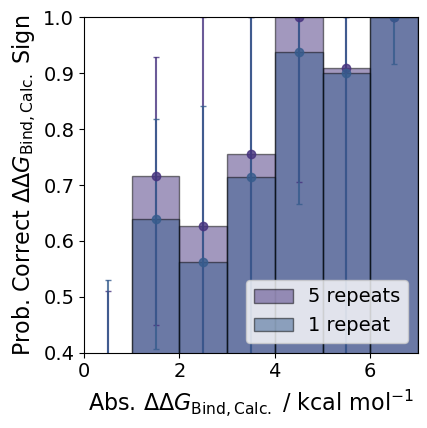

In [39]:
# Plot the 5 repeats and two repeats on the same plot
fig, ax = _plt.subplots(1, 1, figsize=(4.5, 4.5))
# Change the style of the error bars
ax.errorbar([x+0.5 for x in bins[:-1]], means_5, yerr=[means_5 - lower_errs_5, upper_errs_5 - means_5], fmt="o", capsize=2, alpha=0.8)
ax.errorbar([x+0.5 for x in bins[:-1]], means_1, yerr=[means_1 - lower_errs_1, upper_errs_1 - means_1], fmt="o", capsize=2, alpha=0.8)
ax.bar([x+0.5 for x in bins[:-1]], means_5, width=1, alpha=0.5, edgecolor="black", capsize=2, label="5 repeats")
ax.bar([x+0.5 for x in bins[:-1]], means_1, width=1, alpha=0.5, edgecolor="black", capsize=2, label="1 repeat")
ax.set_xlabel("Abs. $\Delta \Delta G_{\mathrm{Bind, Calc.}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Prob. Correct $\Delta \Delta G_{\mathrm{Bind, Calc.}}$ Sign")
ax.set_ylim([0.4, 1.])
ax.set_xlim([0, 7])
ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("analysis/prob_correct_ranking_binned_boostrapped_comparison_by_calc.png", dpi=300, bbox_inches="tight")

## Analyse the Distribution of Experimental $\Delta\Delta G$ vs Calculated $\Delta\Delta G$

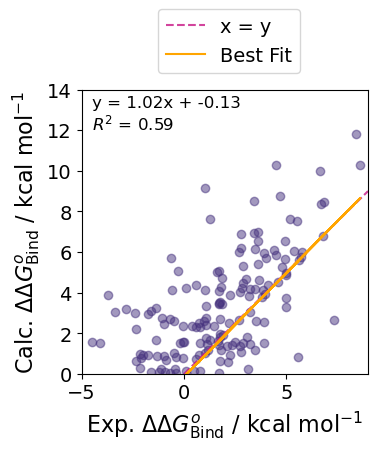

In [40]:
pairs = get_pairs(all_dgs)
calc_dgs = [p.calc_diff for p in pairs]
exp_dgs = [p.exp_diff for p in pairs]

# Fit line of best fit on untransformed data
slope, intercept, r_value, p_value, std_err = linregress(exp_dgs, calc_dgs)

# Flip the signs so that we're only looking at negative calc_dgs
for i in range(len(calc_dgs)):
    if calc_dgs[i] < 0:
        calc_dgs[i] *= -1
        exp_dgs[i] *= -1

fig, ax = _plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(exp_dgs, calc_dgs, alpha=0.5)
ax.set_xlabel("Exp. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Calc. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylim([0, 14])
ax.set_xlim([-5, 9])

# Add line on x = y
ax.plot([0,9], [0,9], color = "#C71585", alpha=0.8, linestyle="--", label="x = y")

# Add line of best fit
line_of_best_fit = slope * np.array(exp_dgs) + intercept
ax.plot(exp_dgs, line_of_best_fit, color="orange", label="Best Fit", linestyle="-")
ax.text(-4.5, 12, f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}", fontsize=12)

fig.legend(loc="center", bbox_to_anchor=(0.6,1.05))
fig.tight_layout()
fig.savefig("analysis/ddg_comparison", dpi=300, bbox_inches="tight")

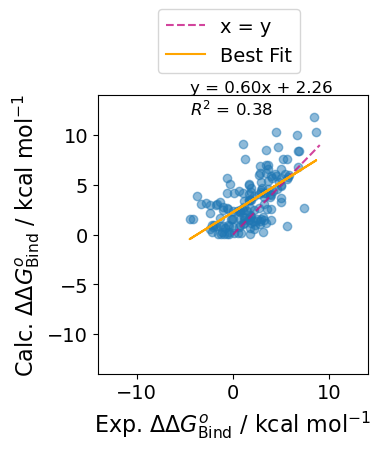

In [15]:
pairs = get_pairs(all_dgs)
calc_dgs = [p.calc_diff for p in pairs]
exp_dgs = [p.exp_diff for p in pairs]

# Fit line of best fit on untransformed data
slope, intercept, r_value, p_value, std_err = linregress(exp_dgs, calc_dgs)

# Flip the signs so that we're only looking at negative calc_dgs
for i in range(len(calc_dgs)):
    if calc_dgs[i] < 0:
        calc_dgs[i] *= -1
        exp_dgs[i] *= -1

# Fit line of best fit on untransformed data
slope, intercept, r_value, p_value, std_err = linregress(exp_dgs, calc_dgs)

fig, ax = _plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(exp_dgs, calc_dgs, alpha=0.5)
ax.set_xlabel("Exp. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Calc. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylim([-14, 14])
ax.set_xlim([-14, 14])

# Add line on x = y
ax.plot([0,9], [0,9], color = "#C71585", alpha=0.8, linestyle="--", label="x = y")

# Add line of best fit
line_of_best_fit = slope * np.array(exp_dgs) + intercept
ax.plot(exp_dgs, line_of_best_fit, color="orange", label="Best Fit", linestyle="-")
ax.text(-4.5, 12, f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}", fontsize=12)

fig.legend(loc="center", bbox_to_anchor=(0.6,1.05))
fig.tight_layout()

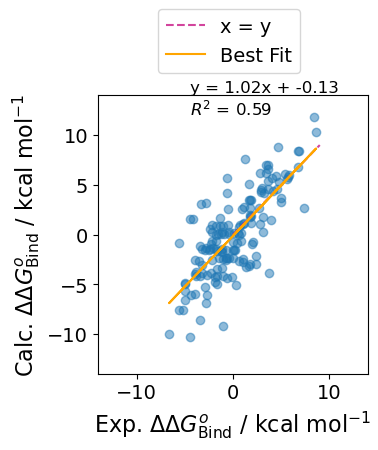

In [16]:

pairs = get_pairs(all_dgs)
calc_dgs = [p.calc_diff for p in pairs]
exp_dgs = [p.exp_diff for p in pairs]

# Fit line of best fit on untransformed data
slope, intercept, r_value, p_value, std_err = linregress(exp_dgs, calc_dgs)


fig, ax = _plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(exp_dgs, calc_dgs, alpha=0.5)
ax.set_xlabel("Exp. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylabel("Calc. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
ax.set_ylim([-14, 14])
ax.set_xlim([-14, 14])

# Add line on x = y
ax.plot([0,9], [0,9], color = "#C71585", alpha=0.8, linestyle="--", label="x = y")

# Add line of best fit
line_of_best_fit = slope * np.array(exp_dgs) + intercept
ax.plot(exp_dgs, line_of_best_fit, color="orange", label="Best Fit", linestyle="-")
ax.text(-4.5, 12, f"y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}", fontsize=12)

fig.legend(loc="center", bbox_to_anchor=(0.6,1.05))
fig.tight_layout()

In [46]:
# Plot the distrbution of ddgs between all pairs

p = pairs[0]

In [47]:
p.abs_calc_diff

Pair(lig1=Result(exp_dg=-4.02, calc_dgs=[-10.754320209126128, -11.302691209126124, -11.12245320912612, -12.704290209126125, -10.768725209126124]), lig2=Result(exp_dg=-10.86, calc_dgs=[-20.83621714381343, -18.86633014381341, -22.078740143813437, -21.500888143813413, -15.62681014381343]))

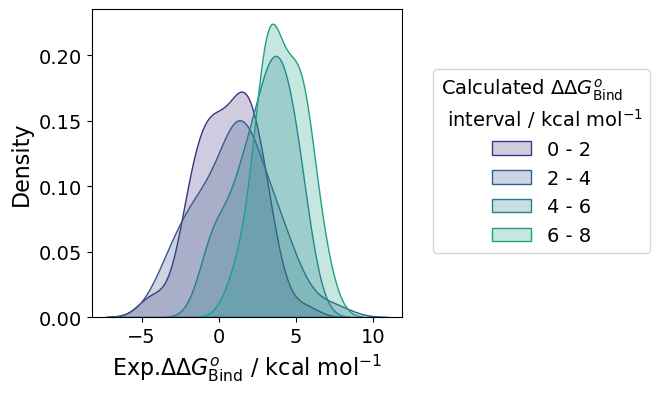

In [41]:
# Plot the kernel denisty estimates of the distributions of experimental dGs after binning into 1 kcal mol bins

bins = _np.arange(0, 10, 2)
# bins =[0,4,8]
fig, ax = _plt.subplots(1, 1, figsize=(4, 4))

for i in range(len(bins)-1):
    bin_pairs = [pair for pair in pairs if bins[i] <= abs(pair.calc_diff) < bins[i + 1]]
    # Switch the experimental dgs to match the use of absolute above
    exp_dgs = [p.exp_diff if p.calc_diff > 0 else -p.exp_diff for p in bin_pairs]
    upper_lim = bins[i+1]
    lower_lim = bins[i]
    sns.kdeplot(ax=ax, data=exp_dgs, fill=True, label = f"{lower_lim} - {upper_lim}")
    # Print the 

ax.set_xlabel("Exp.$\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
fig.legend(loc="center", bbox_to_anchor=(1.25, 0.5), title="Calculated $\Delta \Delta G^o_{\mathrm{Bind}}$\n interval / kcal mol$^{-1}$")
fig.savefig("analysis/ddg_kde", dpi=300, bbox_inches="tight")


In [54]:
bin_name

'    $\\Delta \\Delta G^o_{\\mathrm{Bind, Calc.}}$\n 6 - 8 / kcal mol$^{-1}$'

In [56]:
df[df["bin_name"] == '    $\\Delta \\Delta G^o_{\\mathrm{Bind, Calc.}}$\n 6 - 8 / kcal mol$^{-1}$']

,bin_name,p_i,exp_dg
129,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",0,5.76
130,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",1,5.38
131,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",2,3.62
132,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",3,1.26
133,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",4,4.93
134,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",5,2.80
135,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",6,5.55
136,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",7,5.17
137,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",8,6.78
138,"$\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$...",9,4.40


0
2
[Pair(lig1=Result(exp_dg=-4.02, calc_dgs=[-10.754320209126128, -11.302691209126124, -11.12245320912612, -12.704290209126125, -10.768725209126124]), lig2=Result(exp_dg=-5.93, calc_dgs=[-12.882245926061165, -13.071738926061157, -16.395684926061154, -10.48683392606116, -13.32044692606116])), Pair(lig1=Result(exp_dg=-4.02, calc_dgs=[-10.754320209126128, -11.302691209126124, -11.12245320912612, -12.704290209126125, -10.768725209126124]), lig2=Result(exp_dg=-4.23, calc_dgs=[-9.874234918871265, -9.499845918871262, -11.634762918871262, -8.152944918871263, -9.82551591887126])), Pair(lig1=Result(exp_dg=-10.86, calc_dgs=[-20.83621714381343, -18.86633014381341, -22.078740143813437, -21.500888143813413, -15.62681014381343]), lig2=Result(exp_dg=-8.73, calc_dgs=[-19.544933456487964, -20.885520456487967, -20.328429456487964, -20.030601456487968, -19.70154345648797])), Pair(lig1=Result(exp_dg=-10.86, calc_dgs=[-20.83621714381343, -18.86633014381341, -22.078740143813437, -21.500888143813413, -15.626

/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`

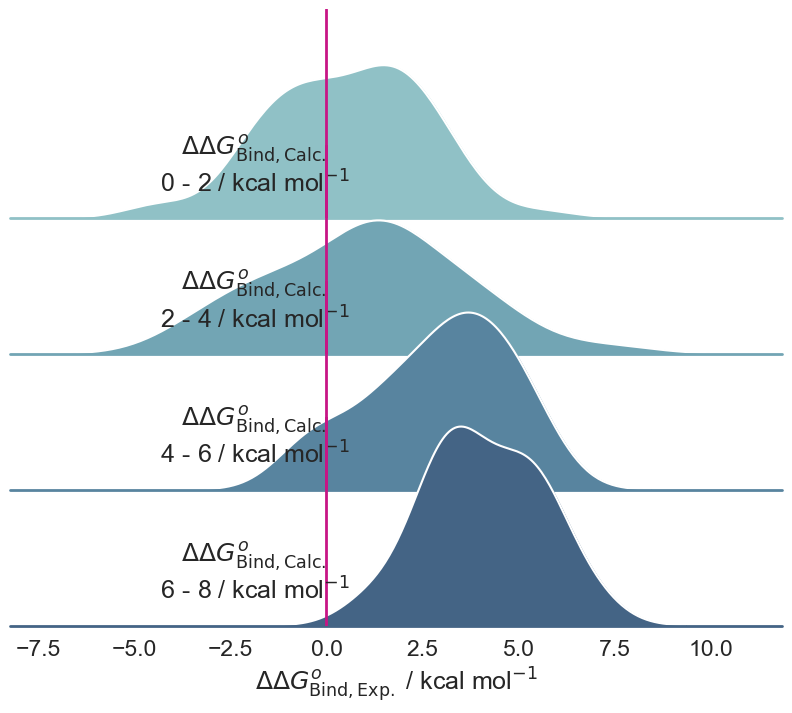

In [57]:
# Plot the above in a different way - start by adding everything to a dataframe
df_data =[]
bins = _np.arange(0, 10, 2)
bin_names =[]

for i in range(len(bins)-1):
    bin_pairs = [pair for pair in pairs if bins[i] <= abs(pair.calc_diff) < bins[i + 1]]
    # Switch the experimental dgs to match the use of absolute above
    exp_dgs = [p.exp_diff if p.calc_diff > 0 else -p.exp_diff for p in bin_pairs]
    upper_lim = bins[i+1]
    lower_lim = bins[i]
    print(lower_lim)
    print(upper_lim)
    print(bin_pairs)
    bin_name = "    $\Delta \Delta G^o_{\mathrm{Bind, Calc.}}$\n" +f" {lower_lim} - {upper_lim}" + " / kcal mol$^{-1}$"
    bin_names.append(bin_name)
    for p_i in range(len(bin_pairs)):
        df_data.append({"bin_name": bin_name, "p_i":p_i, "exp_dg":exp_dgs[p_i]})

df = pd.DataFrame(df_data)
# Credit to Pat Walters https://github.com/PatWalters/plotting_distributions/blob/master/distributions.ipynb

def label(x, color, label):
    ax = plt.gca()
    ax.text(3.3,0.05,label,color="black",fontsize=16)

# set up the plot aesthetics
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
pal = sns.cubehelix_palette(len(bins)+1, rot=-.25, light=.7)
# pal = sns.color_palette("viridis", len(bins)-1)

# set up the facet grid
g = sns.FacetGrid(df, row="bin_name", hue="bin_name", aspect=4.5, height=2, palette=pal)

# plot the kde plots
# g.map(sns.kdeplot,"exp_dg",clip_on=True,shade=True)#alpha=0.5,lw=1.5,bw=0.2)
# g.map(sns.kdeplot, "exp_dg", clip_on=False, color="w", alpha=0.5)
# g.map(sns.kdeplot,"exp_dg",clip_on=True,shade=True,alpha=1,lw=1.5,bw=0.2)
# g.map(sns.kdeplot, "exp_dg", clip_on=False, color="w", lw=2, bw=.2, alpha=1)
g.map(sns.kdeplot,"exp_dg",clip_on=True,shade=True,alpha=1)
g.map(sns.kdeplot, "exp_dg", clip_on=False, color="w", alpha=1)
g.map(plt.axhline, y=0, lw=2, clip_on=False, alpha=1)

# put the target names on the plots
# g.map(label,"bin_name")

# a bunch of fiddling to make the plots pretty
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.35)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
_ = g.axes[-1][0].set_xlabel("$\Delta \Delta G^o_{\mathrm{Bind, Exp.}}$ / kcal mol$^{-1}$")

# Add a vertical line at ddg = 0 and remove y labels
for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(x=00, color="#C71585", ls="-", alpha=1, linewidth=2)
    ax.set_ylabel("")
    ax.text(-4.5, 0.03, bin_names[i])

#g.savefig("analysis/ddg_kde_split", dpi=300, bbox_inches="tight")

/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  func(*plot_args, **plot_kwargs)
/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/home/finlayclark/anaconda3/envs/mamba/envs/a3fe/lib/python3.10/site-packages/seaborn/axisgrid.py:854: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.2`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  func(

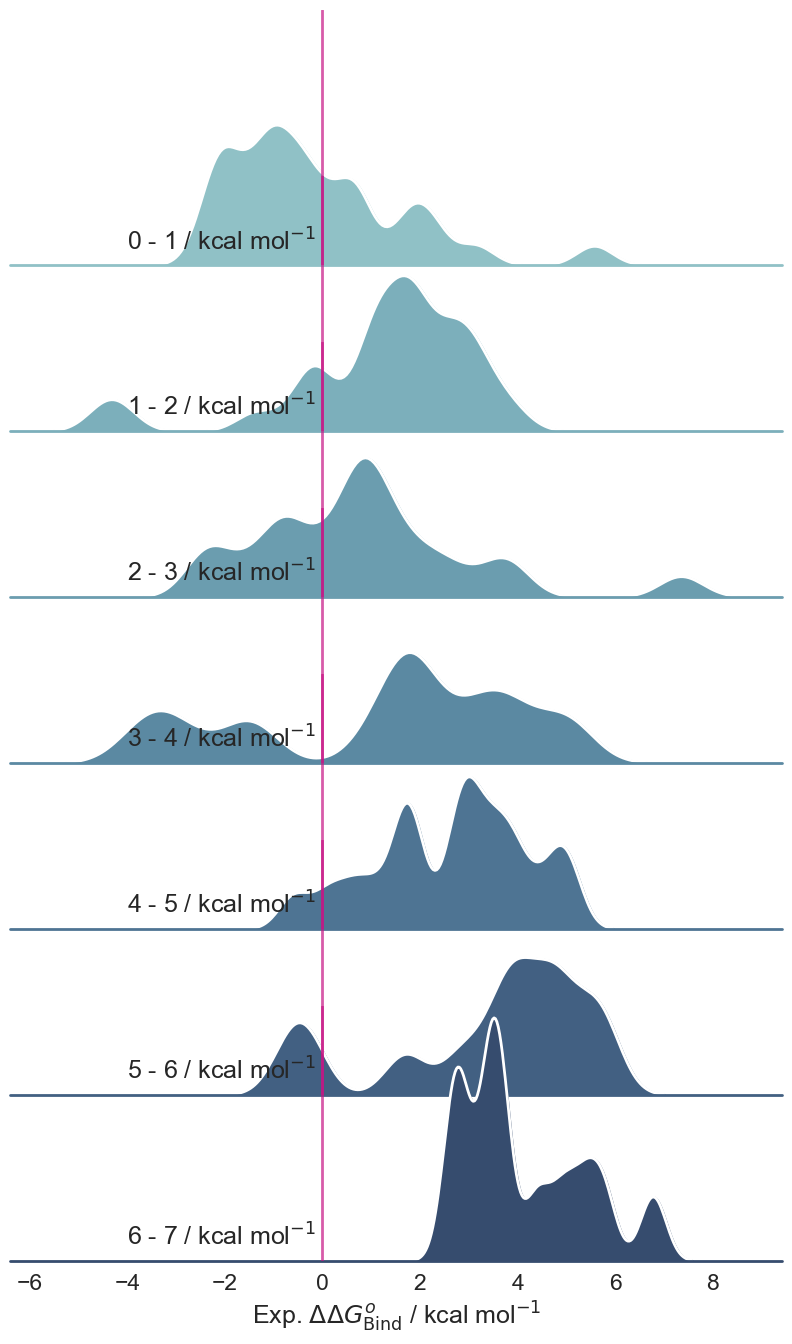

In [44]:
# Plot the above in a different way - start by adding everything to a dataframe
df_data =[]
bins = _np.arange(0, 8, 1)
bin_names =[]

for i in range(len(bins)-1):
    bin_pairs = [pair for pair in pairs if bins[i] <= abs(pair.calc_diff) < bins[i + 1]]
    # Switch the experimental dgs to match the use of absolute above
    exp_dgs = [p.exp_diff if p.calc_diff > 0 else -p.exp_diff for p in bin_pairs]
    upper_lim = bins[i+1]
    lower_lim = bins[i]
    bin_name = f"{lower_lim} - {upper_lim}" +" / kcal mol$^{-1}$"
    bin_names.append(bin_name)
    for p_i in range(len(bin_pairs)):
        df_data.append({"bin_name": bin_name, "p_i":p_i, "exp_dg":exp_dgs[p_i]})

df = pd.DataFrame(df_data)
# Credit to Pat Walters https://github.com/PatWalters/plotting_distributions/blob/master/distributions.ipynb

def label(x, color, label):
    ax = plt.gca()
    ax.text(3.3,0.05,label,color="black",fontsize=16)

# set up the plot aesthetics
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
pal = sns.cubehelix_palette(len(bins)+1, rot=-.25, light=.7)
# pal = sns.color_palette("viridis", len(bins)-1)

# set up the facet grid
g = sns.FacetGrid(df, row="bin_name", hue="bin_name", aspect=4.5, height=2, palette=pal)

# plot the kde plots
# g.map(sns.kdeplot,"exp_dg",clip_on=True,shade=True)#alpha=0.5,lw=1.5,bw=0.2)
# g.map(sns.kdeplot, "exp_dg", clip_on=False, color="w", alpha=0.5)
g.map(sns.kdeplot,"exp_dg",clip_on=True,shade=True,alpha=1,lw=1.5,bw=0.2)
g.map(sns.kdeplot, "exp_dg", clip_on=False, color="w", lw=2, bw=.2, alpha=1)
g.map(plt.axhline, y=0, lw=2, clip_on=False, alpha=1)

# put the target names on the plots
# g.map(label,"bin_name")

# a bunch of fiddling to make the plots pretty
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.35)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
_ = g.axes[-1][0].set_xlabel("Exp. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")

# Add a vertical line at ddg = 0 and remove y labels
for i, ax in enumerate(g.axes.flatten()):
    ax.axvline(x=00, color="#C71585", ls="-", alpha=0.7, linewidth=2)
    ax.set_ylabel("")
    ax.text(-4, 0.03, bin_names[i])

# g.savefig("analysis/ddg_kde_split", dpi=300, bbox_inches="tight")

In [59]:
slope

1.3131382455962204

So we're getting overprediction of the free energy changes

In [58]:
# Functions to do the above, starting from the ligands

def get_pairs(ligands: _pd.DataFrame) -> _List[Pair]:
    """
    Get all pairs of ligands from the ligands dataframe
    """
    pairs = []
    for i in range(len(ligands)):
        for j in range(i + 1, len(ligands)):
            pair = Pair(
                lig1=Result(ligands["exp_dg"][i], ligands["mean_dg"][i]),
                lig2=Result(ligands["exp_dg"][j], ligands["mean_dg"][j])
            )
            pairs.append(pair)
    return pairs

def get_prob_correct_ranking(pairs: _List[Pair], bins: _np.ndarray) -> _Tuple[_np.ndarray, _np.ndarray]:
    """
    Get the average probability of correct ranking as a function of the experimental difference between the dg of the two ligands
    Bin into 1 kcal/mol bins
    """
    prob_correct = []
    pairs_binned = []
    for i in range(len(bins) - 1):
        bin_pairs = [pair for pair in pairs if bins[i] <= pair.abs_exp_diff < bins[i + 1]]
        if len(bin_pairs) == 0:
            prob_correct.append(0)
            continue
        prob_correct.append(len([pair for pair in bin_pairs if pair.correct_ranking]) / len(bin_pairs))
        pairs_binned.append(bin_pairs)
    return prob_correct, pairs_binned

def plot_prob_correct_ranking(prob_correct: _np.ndarray, bins: _np.ndarray, output_dir: str):
    """
    Plot the average probability of correct ranking as a function of the experimental difference between the dg of the two ligands
    Bin into 1 kcal/mol bins
    """
    # Set nice colour scheme
    sns.set_palette("viridis")

    # Plot bars for each binned region
    fig, ax = _plt.subplots(1, 1, figsize=(4, 4))
    # Set grid, but make sure it's behind the bars
    ax.bar([x+0.5 for x in bins[:-1]], prob_correct, width=1, alpha=0.5, edgecolor="black")
    ax.set_xlabel("Abs. $\Delta \Delta G^o_{\mathrm{Bind}}$ / kcal mol$^{-1}$")
    ax.set_ylabel("Prob. Correct $\Delta \Delta G^o_{\mathrm{Bind}}$ Sign")
    ax.set_ylim([0.5, 1])
    ax.set_xlim([0, 7])
    fig.tight_layout()
    fig.savefig(f"{output_dir}/prob_correct_ranking.png", dpi=300)

def get_ligands(all_dgs: _pd.DataFrame) -> _pd.DataFrame:
    """
    Get the ligands from the all_dgs dataframe
    """
    # Add a column to the dataframe with the mean dg
    all_dgs["mean_dg"] = all_dgs.filter(like="calc_dg").mean(axis=1)

    # Sort by experimental dg
    all_dgs.sort_values("exp_dg")
    return all_dgs

def boostrap_results(results: _List[Result], n_bootstrap: int = 10_000) -> _List[_List[Result]]:
    """
    Bootstrap the ligands
    """
    bootstrapped_results = []
    for i in range(n_bootstrap):
        bootstrapped_results.append(_np.random.choice(results, size=len(results), replace=True))
    return bootstrapped_results

def get_bootstrapped_pairs(bootstrapped_results: _List[_List[Result]]) -> _List[_List[Pair]]:
    """
    Get the bootstrapped pairs
    """
    bootstrapped_pairs = []
    for results in bootstrapped_results:
        bootstrapped_pairs.append(get_pairs(results))
    return bootstrapped_pairs

    

In [59]:
ligands

,name,calc_base_dir,exp_dg,exp_er,calc_cor,calc_dg_1,calc_er_1,calc_dg_2,calc_er_2,calc_dg_3,calc_er_3,calc_dg_4,calc_er_4,calc_dg_5,calc_er_5,mean_dg
0,CHEMBL255949,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-7.155012,0.5,0,-14.035444,0.688300,-12.101993,0.701759,-13.224955,0.681618,-13.665827,0.670807,-14.014849,0.689551,-13.408614
1,CHEMBL402934,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.332492,0.5,0,-20.478672,0.643115,-16.537198,0.653057,-19.177837,0.636487,-19.676177,0.656454,-19.748593,0.636798,-19.123696
2,CHEMBL402933,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-7.638918,0.5,0,-16.707138,0.674237,-15.307334,0.668003,-16.745580,0.664997,-18.023844,0.678129,-17.201879,0.665939,-16.797155
3,CHEMBL256724,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.509260,0.5,0,-17.975554,0.670950,-18.750851,0.662799,-20.414967,0.654810,-16.976771,0.650232,-21.811930,0.656743,-19.186015
4,CHEMBL402584,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-7.764328,0.5,0,-21.629104,0.641717,-20.729340,0.651153,-18.195320,0.661041,-22.265499,0.645875,-19.829312,0.642997,-20.529715
5,CHEMBL254588,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.946066,0.5,0,-22.625324,0.678952,-21.040617,0.674841,-21.168049,0.685858,-22.065624,0.672937,-25.198763,0.675490,-22.419675
6,CHEMBL258435,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.459882,0.5,0,-20.106536,0.683978,-19.651784,0.681310,-20.914369,0.692243,-18.224247,0.691083,-17.198861,0.690391,-19.219160
7,CHEMBL257576,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.199583,0.5,0,-22.851164,0.680041,-22.612339,0.679409,-22.008628,0.700529,-22.915759,0.680461,-22.282713,0.670886,-22.534121
8,CHEMBL401907,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-8.423144,0.5,0,-22.889684,0.641494,-20.364134,0.668715,-19.137440,0.658918,-23.641076,0.666201,-17.670533,0.669895,-20.740574
9,CHEMBL255947,/projects/cc/clark_kbtd104/projects/ephb4_a3fe...,-7.530947,0.5,0,-21.824783,0.644436,-14.907495,0.681232,-19.858618,0.667177,-21.863982,0.661987,-18.349026,0.680782,-19.360781


In [13]:
bins

array([0, 1, 2, 3, 4, 5, 6, 7])

In [16]:
pairs_binned[-4]

[Pair(lig1=Result(exp_dg=-7.155011760072152, calc_dg=-13.408613894611744), lig2=Result(exp_dg=-10.498245637134056, calc_dg=-20.86688115461201)),
 Pair(lig1=Result(exp_dg=-7.155011760072152, calc_dg=-13.408613894611744), lig2=Result(exp_dg=-10.82596029976637, calc_dg=-22.821651727130916)),
 Pair(lig1=Result(exp_dg=-7.155011760072152, calc_dg=-13.408613894611744), lig2=Result(exp_dg=-11.079092540402325, calc_dg=-22.836237376572694)),
 Pair(lig1=Result(exp_dg=-8.33249226744346, calc_dg=-19.123695652760638), lig2=Result(exp_dg=-12.27231775000893, calc_dg=-25.561275139715985)),
 Pair(lig1=Result(exp_dg=-8.33249226744346, calc_dg=-19.123695652760638), lig2=Result(exp_dg=-12.27231775000893, calc_dg=-22.95535061994583)),
 Pair(lig1=Result(exp_dg=-8.33249226744346, calc_dg=-19.123695652760638), lig2=Result(exp_dg=-12.27231775000893, calc_dg=-25.517232066937378)),
 Pair(lig1=Result(exp_dg=-7.638918259641302, calc_dg=-16.797155276130002), lig2=Result(exp_dg=-11.1638364417264, calc_dg=-25.28112923

In [ ]:


all_dgs["calc_dg"] = _np.nan
all_dgs["calc_er"] = _np.nan

# Get the calculated dGs
# for calc in self.calcs:
for calc_path in self.calc_paths:
    # For now, just pull the results from the output files
    with open(
        _os.path.join(calc_path, "output", "overall_stats.dat"), "rt"
    ) as ifile:
        lines = ifile.readlines()
        dg = float(lines[1].split(" ")[3])
        conf_int = float(lines[1].split(" ")[-2])
        print(dg, conf_int)
    # Get the name of the ligand for the calculation and use this to add the results
    name = all_dgs.index[all_dgs.index == calc_path]
    # Make sure that there is only one row with this name
    if not len(name) == 1:
        raise ValueError(
            f"Found {len(name)} rows matching {calc_path} in experimental dGs file"
        )
    all_dgs.loc[name, "calc_dg"] = dg
    all_dgs.loc[name, "calc_er"] = conf_int

    # Remove the calcultion from memory
    # calc._close_logging_handlers()
    # del calc

# Offset the calculated values with their corrections
all_dgs["calc_dg"] += all_dgs["calc_cor"]

# Save results including NaNs
all_dgs.to_csv(_os.path.join(self.output_dir, "results_summary"), sep=",")

# Exclude rows with NaN
all_dgs.dropna(inplace=True)

# Offset the results if required
if offset:
    shift = all_dgs["exp_dg"].mean() - all_dgs["calc_dg"].mean()
    all_dgs["calc_dg"] += shift

# Calculate statistics and save results
stats = _compute_stats(all_dgs)
name = "overall_stats_offset.txt" if offset else "overall_stats.txt"
with open(_os.path.join(self.output_dir, name), "wt") as ofile:
    for stat in stats:
        ofile.write(
            f"{stat}: {stats[stat][0]:.2f} ({stats[stat][1]:.2f}, {stats[stat][2]:.2f})\n"
        )

# Plot
_plt_against_exp(
    all_results=all_dgs, output_dir=self.output_dir, offset=offset, stats=stats
)
